 # Enhanced Rank Prediction Analysis

 This notebook analyzes and predicts future rankings based on historical data with:

 - Advanced visualizations

 - Hyperparameter tuning

 - Multiple evaluation metrics

 - Targeted forecasting

 ## Imports

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import lightgbm as lgbm
import xgboost as xgb
from scipy.stats import uniform, randint

# Set notebook display options
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


 ## Data Loading and Exploration Functions

In [69]:
def load_and_explore_data(file_path):
    """
    Load and perform initial exploration of the data
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        Pandas DataFrame with the data
    """
    print("Loading data...")
    df = pd.read_csv(file_path)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of unique subjects: {df['SubjectID'].nunique()}")
    
    # Convert date column
    df['UpdateDT'] = pd.to_datetime(df['UpdateDT'])
    print(f"Date range: {df['UpdateDT'].min()} to {df['UpdateDT'].max()}")
    
    # Remove duplicate entries
    print("\nChecking for duplicate entries...")
    
    # First, check for exact duplicates
    original_rows = df.shape[0]
    df = df.drop_duplicates()
    exact_dupes = original_rows - df.shape[0]
    if exact_dupes > 0:
        print(f"Removed {exact_dupes} exact duplicate rows")
    else:
        print("No exact duplicates found")

    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values:")
        print(missing_values[missing_values > 0])
    else:
        print("\nNo missing values found.")
    
    # Summary statistics for rank
    print("\nRank statistics:")
    print(df['Rank'].describe())
    
    # Check number of observations per subject
    subject_counts = df['SubjectID'].value_counts()
    print(f"\nObservations per subject - Min: {subject_counts.min()}, Max: {subject_counts.max()}, Avg: {subject_counts.mean():.2f}")
    
    # Analyze update frequency
    df_sorted = df.sort_values(['SubjectID', 'UpdateDT'])
    df_sorted['TimeDiff'] = df_sorted.groupby('SubjectID')['UpdateDT'].diff()
    
    # Filter out first observation per subject (which will have NaN TimeDiff)
    time_diffs = df_sorted.dropna(subset=['TimeDiff'])['TimeDiff']
    
    print("\nTime between updates (days):")
    print(f"Min: {time_diffs.dt.days.min()}")
    print(f"Max: {time_diffs.dt.days.max()}")
    print(f"Mean: {time_diffs.dt.days.mean():.2f}")
    print(f"Median: {time_diffs.dt.days.median():.2f}")
    
    # Additional visualizations
    plt.figure(figsize=(10, 6))
    plt.hist(df['Rank'], bins=50, alpha=0.7)
    plt.title('Distribution of Ranks')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Rank distribution over time
    plt.figure(figsize=(12, 6))
    df_sample = df.sample(min(5000, len(df)))  # Sample to avoid overcrowding the plot
    plt.scatter(df_sample['UpdateDT'], df_sample['Rank'], alpha=0.5, s=5)
    plt.title('Rank Distribution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Rank')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Subject update frequency
    plt.figure(figsize=(10, 6))
    plt.hist(subject_counts, bins=30, alpha=0.7)
    plt.title('Number of Updates per Subject')
    plt.xlabel('Number of Updates')
    plt.ylabel('Number of Subjects')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return df


In [70]:
def analyze_factor_patterns(df):
    """
    Analyze patterns in the factor data
    
    Args:
        df: Pandas DataFrame with the data
        
    Returns:
        Set of all unique factors
    """
    print("\nAnalyzing factor patterns...")
    
    # Get all driver columns
    driver_cols = [f'Driver{i}' for i in range(1, 18)]
    
    # Count unique factors across all driver columns
    all_factors = set()
    for col in driver_cols:
        all_factors.update(df[col].unique())
    
    print(f"Number of unique factors: {len(all_factors)}")
    print(f"Factors: {sorted(all_factors)}")
    
    # Analyze factor positions
    factor_positions = {}
    
    for factor in all_factors:
        positions = []
        for i in range(1, 18):
            driver_col = f'Driver{i}'
            count = (df[driver_col] == factor).sum()
            positions.append(count)
        factor_positions[factor] = positions
    
    # Convert to DataFrame
    factor_df = pd.DataFrame(factor_positions, index=[f'Pos{i}' for i in range(1, 18)])
    
    # Calculate total occurrences for each factor
    factor_totals = factor_df.sum()
    
    print("\nFactor occurrence frequency:")
    for factor, count in factor_totals.sort_values(ascending=False).head(5).items():
        print(f"{factor}: {count} occurrences")
    
    # Plot position distribution for top factors
    top_factors = factor_totals.sort_values(ascending=False).head(5).index
    
    plt.figure(figsize=(12, 8))
    for factor in top_factors:
        plt.plot(range(1, 18), factor_df[factor], label=factor)
    
    plt.xlabel('Position')
    plt.ylabel('Frequency')
    plt.title('Position Distribution of Top 5 Factors')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Analyze factor-rank relationship
    factor_ranks = {}
    
    for i in range(1, 18):
        driver_col = f'Driver{i}'
        for factor in all_factors:
            factor_key = f"{factor}_Pos{i}"
            avg_rank = df[df[driver_col] == factor]['Rank'].mean()
            factor_ranks[factor_key] = avg_rank
    
    # Convert to DataFrame and sort
    factor_rank_df = pd.DataFrame(list(factor_ranks.items()), columns=['Factor_Position', 'AvgRank'])
    factor_rank_df[['Factor', 'Position']] = factor_rank_df['Factor_Position'].str.split('_Pos', expand=True)
    factor_rank_df['Position'] = factor_rank_df['Position'].astype(int)
    
    # Sort by average rank
    factor_rank_df = factor_rank_df.sort_values('AvgRank')
    
    print("\nTop 10 factor-position combinations with lowest average rank (highest risk):")
    print(factor_rank_df.head(10))
    
    # Plot factor-rank relationship for top factors
    plt.figure(figsize=(14, 10))
    
    for factor in top_factors:
        factor_data = factor_rank_df[factor_rank_df['Factor'] == factor]
        plt.plot(factor_data['Position'], factor_data['AvgRank'], marker='o', label=factor)
    
    plt.xlabel('Position')
    plt.ylabel('Average Rank')
    plt.title('Average Rank by Factor Position')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Create a heatmap of top factor positions and average ranks
    # Reshape data for heatmap
    heatmap_data = factor_rank_df.pivot(index='Factor', columns='Position', values='AvgRank')
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(heatmap_data, annot=False, cmap='viridis_r', linewidths=0.5)
    plt.title('Average Rank by Factor and Position (Darker = Lower Rank = Higher Risk)')
    plt.show()
    
    return all_factors


 ## Data Preprocessing Function

In [71]:
def preprocess_data(df, all_factors):
    """
    Preprocess the data for modeling:
    - Convert factor data to numeric features
    - Handle temporal features
    - Split into features and target
    
    Args:
        df: Pandas DataFrame with the data
        all_factors: Set of all unique factors
        
    Returns:
        Processed DataFrame ready for modeling
    """
    print("\nPreprocessing data...")
    
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Convert date to datetime if not already done
    processed_df['UpdateDT'] = pd.to_datetime(processed_df['UpdateDT'])
    
    # Extract date components
    processed_df['Year'] = processed_df['UpdateDT'].dt.year
    processed_df['Month'] = processed_df['UpdateDT'].dt.month
    processed_df['Day'] = processed_df['UpdateDT'].dt.day
    processed_df['DayOfWeek'] = processed_df['UpdateDT'].dt.dayofweek
    processed_df['DayOfYear'] = processed_df['UpdateDT'].dt.dayofyear
    
    # Calculate days since first observation
    min_date = processed_df['UpdateDT'].min()
    processed_df['DaysSinceStart'] = (processed_df['UpdateDT'] - min_date).dt.days
    
    # One-hot encode the factors in each driver position
    print("Performing one-hot encoding for factors...")
    driver_cols = [f'Driver{i}' for i in range(1, 18)]
    
    # Create binary features for each factor and position
    for i, driver_col in enumerate(driver_cols, 1):
        for factor in all_factors:
            feat_name = f'{factor}_Pos{i}'
            processed_df[feat_name] = (processed_df[driver_col] == factor).astype(int)
    
    # Add features for factor frequency and positions
    print("Adding factor frequency and position features...")
    
    # Prepare list to collect all rows
    all_rows = []
    
    # Group by Subject ID and date to get the time-based view
    for (subject_id, update_dt), group in processed_df.groupby(['SubjectID', 'UpdateDT']):
        # There should be only one row per subject/date, but just in case
        if len(group) > 1:
            group = group.iloc[0:1]
        
        row = group.iloc[0].to_dict()
        
        # Calculate position metrics for each factor
        for factor in all_factors:
            # Find the position of this factor (if present)
            factor_present = False
            for i in range(1, 18):
                driver_col = f'Driver{i}'
                if row[driver_col] == factor:
                    row[f'{factor}_Position'] = i
                    factor_present = True
                    break
            
            if not factor_present:
                row[f'{factor}_Position'] = 0
        
        all_rows.append(row)
    
    # Create new DataFrame from processed rows
    enhanced_df = pd.DataFrame(all_rows)
    
    # Sort by SubjectID and UpdateDT to respect time order
    enhanced_df = enhanced_df.sort_values(['SubjectID', 'UpdateDT'])
    
    # Calculate lagged features and rank changes
    print("Adding time-based features...")
    
    # Calculate previous rank and rank change for each subject
    enhanced_df['PrevRank'] = enhanced_df.groupby('SubjectID')['Rank'].shift(1)
    enhanced_df['RankChange'] = enhanced_df['Rank'] - enhanced_df['PrevRank']
    
    # Calculate position changes for each factor
    for factor in all_factors:
        enhanced_df[f'{factor}_PrevPosition'] = enhanced_df.groupby('SubjectID')[f'{factor}_Position'].shift(1)
        enhanced_df[f'{factor}_PositionChange'] = enhanced_df[f'{factor}_Position'] - enhanced_df[f'{factor}_PrevPosition']
    
    # Calculate time since last update
    enhanced_df['PrevUpdateDT'] = enhanced_df.groupby('SubjectID')['UpdateDT'].shift(1)
    enhanced_df['DaysSinceLastUpdate'] = (enhanced_df['UpdateDT'] - enhanced_df['PrevUpdateDT']).dt.days
    
    # Replace NaN with 0 (for first observations)
    for col in enhanced_df.columns:
        if enhanced_df[col].dtype == 'float64' and enhanced_df[col].isna().any():
            enhanced_df[col] = enhanced_df[col].fillna(0)
    
    # Drop original driver columns as we now have encoded features
    enhanced_df = enhanced_df.drop(driver_cols, axis=1)
    
    print(f"Processed DataFrame shape: {enhanced_df.shape}")
    
    # Visualize rank changes
    plt.figure(figsize=(10, 6))
    plt.hist(enhanced_df['RankChange'].dropna(), bins=50, alpha=0.7)
    plt.title('Distribution of Rank Changes')
    plt.xlabel('Rank Change')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Feature correlation
    numeric_df = enhanced_df.select_dtypes(include=['int64', 'float64'])
    corr_cols = ['Rank', 'RankChange', 'DaysSinceLastUpdate', 'PrevRank']
    corr_df = numeric_df[corr_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Key Features')
    plt.show()
    
    return enhanced_df


 ## Model Preparation Function

In [72]:
def prepare_for_modeling(df, test_size=0.2, n_splits=5):
    """
    Prepare the processed data for time-series modeling
    
    Args:
        df: Processed DataFrame
        test_size: Proportion of data to use for testing
        n_splits: Number of splits for time series cross-validation
        
    Returns:
        X_train, X_test, y_train, y_test, feature_columns, tscv
    """
    print("\nPreparing data for modeling...")
    
    # Exclude non-feature columns
    exclude_cols = ['SubjectID', 'Rank', 'UpdateDT', 'PrevUpdateDT', 'Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear'] #, 'RankChange', 'PrevRank']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Separate features and target
    X = df[feature_cols]
    y = df['Rank']
    
    # Get unique timestamps and sort them
    timestamps = sorted(df['UpdateDT'].unique())
    test_timestamp_idx = int(len(timestamps) * (1 - test_size))
    split_timestamp = timestamps[test_timestamp_idx]
    
    print(f"Training on data before {split_timestamp}")
    print(f"Testing on data on or after {split_timestamp}")
    
    # Split based on timestamp
    train_mask = df['UpdateDT'] < split_timestamp
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[~train_mask]
    y_test = y[~train_mask]
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Create TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Scale numerical features
    numerical_features = [col for col in feature_cols if X[col].dtype != 'object']
    
    scaler = StandardScaler()
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    
    print(feature_cols)

    return X_train, X_test, y_train, y_test, feature_cols, tscv


 ## Custom Evaluation Metrics

In [73]:
def within_range_accuracy(y_true, y_pred, threshold=10):
    """
    Calculate the percentage of predictions that are within a 
    specified threshold of the actual value
    
    Args:
        y_true: Actual values
        y_pred: Predicted values
        threshold: Maximum allowed difference
        
    Returns:
        Percentage of predictions within threshold
    """
    differences = np.abs(y_true - y_pred)
    within_range = np.sum(differences <= threshold)
    return within_range / len(y_true)

def evaluate_model(y_true, y_pred, name="Model"):
    """
    Evaluate a model using multiple metrics
    
    Args:
        y_true: Actual values
        y_pred: Predicted values
        name: Name of the model
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Calculate standard regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Calculate custom accuracy metrics at different thresholds
    acc_5 = within_range_accuracy(y_true, y_pred, 5)
    acc_10 = within_range_accuracy(y_true, y_pred, 10)
    acc_20 = within_range_accuracy(y_true, y_pred, 20)
    
    # Print metrics
    print(f"\n{name} Performance Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"Accuracy within 5 ranks: {acc_5:.2%}")
    print(f"Accuracy within 10 ranks: {acc_10:.2%}")
    print(f"Accuracy within 20 ranks: {acc_20:.2%}")
    
    # Return metrics as a dictionary
    return {
        'name': name,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'acc_5': acc_5,
        'acc_10': acc_10,
        'acc_20': acc_20
    }


 ## Hyperparameter Tuning Functions

In [74]:
def tune_random_forest(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune Random Forest hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning Random Forest hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(10, 50),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['auto', 'sqrt', 'log2', None]
    }
    
    # Create base model
    rf_base = RandomForestRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    rf_search = RandomizedSearchCV(
        rf_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    rf_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {rf_search.best_params_}")
    print(f"Best MAE: {-rf_search.best_score_:.2f}")
    
    return rf_search.best_estimator_

def tune_gradient_boosting(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune Gradient Boosting hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning Gradient Boosting hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'subsample': uniform(0.5, 0.5),
        'max_features': uniform(0.5, 0.5)
    }
    
    # Create base model
    gb_base = GradientBoostingRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    gb_search = RandomizedSearchCV(
        gb_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    gb_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {gb_search.best_params_}")
    print(f"Best MAE: {-gb_search.best_score_:.2f}")
    
    return gb_search.best_estimator_

def tune_lightgbm(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune LightGBM hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning LightGBM hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'num_leaves': randint(20, 100),
        'min_child_samples': randint(10, 50),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5)
    }
    
    # Create base model
    lgbm_base = lgbm.LGBMRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    lgbm_search = RandomizedSearchCV(
        lgbm_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    lgbm_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {lgbm_search.best_params_}")
    print(f"Best MAE: {-lgbm_search.best_score_:.2f}")
    
    return lgbm_search.best_estimator_

def tune_xgboost(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune XGBoost hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning XGBoost hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 10),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 1)
    }
    
    # Create base model
    xgb_base = xgb.XGBRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    xgb_search = RandomizedSearchCV(
        xgb_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    xgb_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {xgb_search.best_params_}")
    print(f"Best MAE: {-xgb_search.best_score_:.2f}")
    
    return xgb_search.best_estimator_


 ## Model Training and Evaluation Functions

In [75]:
def train_and_evaluate_model(model, name, X_train, X_test, y_train, y_test, feature_cols):
    """
    Train and evaluate a single model
    
    Args:
        model: Model instance to train
        name: Name of the model
        X_train, X_test, y_train, y_test: Train/test data
        feature_cols: List of feature columns
        
    Returns:
        Dictionary with model scores and the trained model
    """
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train on full training data
    model.fit(X_train, y_train)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate model
    metrics = evaluate_model(y_test, y_pred, name)
    metrics['train_time'] = train_time
    metrics['model'] = model
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    
    # Create a scatter plot with alpha transparency and darker markers
    plt.scatter(y_test, y_pred, alpha=0.5, s=10, c='blue')
    
    # Add diagonal line for perfect predictions
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add regression line to show trend
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(np.sort(y_test), p(np.sort(y_test)), "g-", alpha=0.7)
    
    plt.xlabel('Actual Rank')
    plt.ylabel('Predicted Rank')
    plt.title(f'{name} - Actual vs Predicted Rank')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot prediction errors
    errors = y_pred - y_test
    
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error (Predicted - Actual)')
    plt.ylabel('Frequency')
    plt.title(f'{name} - Distribution of Prediction Errors')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot errors by actual rank
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, errors, alpha=0.5, s=10, c='blue')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Rank')
    plt.ylabel('Prediction Error')
    plt.title(f'{name} - Prediction Errors by Actual Rank')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot feature importance if available
    if hasattr(model, 'feature_importances_'):
        # Get feature importances
        importance = model.feature_importances_
        
        # Get top features (top 20)
        indices = np.argsort(importance)[::-1]
        top_indices = indices[:20]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importance - {name}')
        plt.bar(range(len(top_indices)), importance[top_indices], align='center')
        plt.xticks(range(len(top_indices)), [feature_cols[i] for i in top_indices], rotation=90)
        plt.tight_layout()
        plt.show()
    
    return metrics


 ## Key Driver Identification Function

In [76]:
def identify_key_drivers(model, feature_cols, all_factors):
    """
    Identify key drivers of rank changes using the trained model
    
    Args:
        model: Trained model
        feature_cols: List of feature columns
        all_factors: Set of all unique factors
        
    Returns:
        Dictionary with driver influence scores
    """
    print("\nIdentifying key drivers of rank changes...")
    
    # Extract feature importances if available
    if not hasattr(model, 'feature_importances_'):
        print("Model doesn't have feature importances attribute.")
        
        # For models without feature_importances_
        if hasattr(model, 'coef_'):
            print("Using coefficient magnitudes as feature importance.")
            
            # For models with coefficients
            if len(model.coef_.shape) == 1:
                # Single set of coefficients
                importance = np.abs(model.coef_)
            else:
                # Multiple sets of coefficients (e.g., for multiple thresholds)
                importance = np.mean(np.abs(model.coef_), axis=0)
                
            # Create feature importance dictionary
            feature_importance = dict(zip(feature_cols, importance))
        else:
            print("Model doesn't have accessible feature importances. Using permutation importance.")
            return None
    else:
        # For models with feature_importances_ attribute
        importance = model.feature_importances_
        feature_importance = dict(zip(feature_cols, importance))
    
    # Aggregate importance by factor
    factor_importance = {}
    
    for factor in all_factors:
        # Sum importances across all features related to this factor
        factor_features = [f for f in feature_cols if factor in f]
        factor_importance[factor] = sum(feature_importance[f] for f in factor_features if f in feature_importance)
    
    # Sort factors by importance
    sorted_factors = sorted(factor_importance.items(), key=lambda x: x[1], reverse=True)
    
    print("\nTop 10 most influential factors:")
    for factor, importance in sorted_factors[:10]:
        print(f"{factor}: {importance:.4f}")
    
    # Visualize factor importance - horizontal bar chart for better readability
    plt.figure(figsize=(12, 10))
    
    # Get all factors and their importances
    factors = [f[0] for f in sorted_factors]
    importances = [f[1] for f in sorted_factors]
    
    # Create horizontal bar chart with color map
    bars = plt.barh(range(len(factors)), importances, align='center', 
                    color=plt.cm.viridis(np.linspace(0, 1, len(factors))))
    
    # Add factor labels
    plt.yticks(range(len(factors)), factors)
    
    # Add importance values to the bars
    for i, (factor, importance) in enumerate(sorted_factors):
        plt.text(importance + 0.01, i, f'{importance:.4f}', 
                 va='center', fontsize=10)
    
    plt.xlabel('Importance Score')
    plt.title('Factor Importance for Rank Prediction (All Factors)')
    plt.tight_layout()
    plt.show()
    
    # Create a more detailed visualization of top factors
    top_n = 10  # Number of top factors to show
    
    plt.figure(figsize=(12, 8))
    
    # Get top factors and their importances
    top_factors = [f[0] for f in sorted_factors[:top_n]]
    top_importances = [f[1] for f in sorted_factors[:top_n]]
    
    # Create horizontal bar chart for top factors
    plt.barh(range(len(top_factors)), top_importances, align='center',
             color=plt.cm.viridis(np.linspace(0, 1, len(top_factors))))
    
    # Add factor labels
    plt.yticks(range(len(top_factors)), top_factors)
    
    # Add importance values to the bars
    for i, (factor, importance) in enumerate(sorted_factors[:top_n]):
        plt.text(importance + 0.01, i, f'{importance:.4f}', 
                 va='center', fontsize=12)
    
    plt.xlabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Factors for Rank Prediction')
    plt.tight_layout()
    plt.show()
    
    return factor_importance


 ## Future Rank Forecasting Functions

In [77]:
def forecast_future_ranks(df, model, feature_cols, all_factors, n_periods=3):
    """
    Forecast future ranks for all subjects
    
    Args:
        df: Processed DataFrame
        model: Trained model
        feature_cols: List of feature columns
        all_factors: Set of all unique factors
        n_periods: Number of future periods to forecast
        
    Returns:
        DataFrame with forecasted ranks
    """
    print(f"\nForecasting future ranks for {n_periods} periods...")
    
    # Group by SubjectID to get latest data for each subject
    latest_data = df.sort_values(['SubjectID', 'UpdateDT']).groupby('SubjectID').last().reset_index()
    
    # List to collect forecasts
    forecasts = []
    
    # For each subject, forecast future ranks
    for _, subject_data in latest_data.iterrows():
        subject_id = subject_data['SubjectID']
        last_update = subject_data['UpdateDT']
        last_rank = subject_data['Rank']
        
        # Create a copy of the subject's data for forecasting
        forecast_data = subject_data.copy()
        
        # Forecast for each future period
        for period in range(1, n_periods + 1):
            # Update date for the forecast period
            # Assuming similar time difference as average in the dataset
            # This is a simplification - could be improved with actual schedule
            new_date = last_update + pd.Timedelta(days=30 * period)  # Assuming monthly updates
            
            # Update temporal features
            forecast_data['UpdateDT'] = new_date
            forecast_data['Year'] = new_date.year
            forecast_data['Month'] = new_date.month
            forecast_data['Day'] = new_date.day
            forecast_data['DayOfWeek'] = new_date.dayofweek
            forecast_data['DayOfYear'] = new_date.dayofyear
            forecast_data['DaysSinceStart'] = (new_date - df['UpdateDT'].min()).days
            forecast_data['DaysSinceLastUpdate'] = (new_date - last_update).days
            
            # Previous rank is the last forecasted rank
            forecast_data['PrevRank'] = last_rank
            
            # Extract features for prediction
            X_forecast = forecast_data[feature_cols].values.reshape(1, -1)
            
            # Make prediction
            predicted_rank = model.predict(X_forecast)[0]
            
            # Round to nearest integer (ranks are typically integers)
            predicted_rank = round(predicted_rank)
            
            # Store forecast
            forecasts.append({
                'SubjectID': subject_id,
                'ForecastPeriod': period,
                'ForecastDate': new_date,
                'PreviousRank': last_rank,
                'ForecastedRank': predicted_rank,
                'RankChange': predicted_rank - last_rank
            })
            
            # Update last_rank for next period
            last_rank = predicted_rank
    
    # Convert to DataFrame
    forecast_df = pd.DataFrame(forecasts)
    
    # Visualize forecasts
    plot_forecasts(forecast_df)
    
    return forecast_df

def forecast_specific_subjects(df, model, feature_cols, all_factors, subject_ids, n_periods=6):
    """
    Forecast future ranks for specific subjects
    
    Args:
        df: Processed DataFrame
        model: Trained model
        feature_cols: List of feature columns
        all_factors: Set of all unique factors
        subject_ids: List of subject IDs to forecast
        n_periods: Number of future periods to forecast
        
    Returns:
        DataFrame with forecasted ranks for specific subjects
    """
    print(f"\nForecasting future ranks for {len(subject_ids)} specific subjects over {n_periods} periods...")
    
    # Group by SubjectID to get latest data for each subject
    latest_data = df.sort_values(['SubjectID', 'UpdateDT']).groupby('SubjectID').last().reset_index()
    
    # Filter for specific subjects
    latest_data = latest_data[latest_data['SubjectID'].isin(subject_ids)]
    
    if len(latest_data) == 0:
        print(f"None of the specified subject IDs were found in the data.")
        return pd.DataFrame()
    
    print(f"Found {len(latest_data)} of the {len(subject_ids)} requested subjects in the data.")
    
    # List to collect forecasts
    forecasts = []
    
    # For each subject, forecast future ranks
    for _, subject_data in latest_data.iterrows():
        subject_id = subject_data['SubjectID']
        last_update = subject_data['UpdateDT']
        last_rank = subject_data['Rank']
        
        print(f"Forecasting for Subject {subject_id}, Last Rank: {last_rank}")
        
        # Create a copy of the subject's data for forecasting
        forecast_data = subject_data.copy()
        
        # Store the initial rank for plotting
        initial_rank = last_rank
        rank_history = [initial_rank]
        
        # Forecast for each future period
        for period in range(1, n_periods + 1):
            # Update date for the forecast period
            new_date = last_update + pd.Timedelta(days=30 * period)  # Assuming monthly updates
            
            # Update temporal features
            forecast_data['UpdateDT'] = new_date
            forecast_data['Year'] = new_date.year
            forecast_data['Month'] = new_date.month
            forecast_data['Day'] = new_date.day
            forecast_data['DayOfWeek'] = new_date.dayofweek
            forecast_data['DayOfYear'] = new_date.dayofyear
            forecast_data['DaysSinceStart'] = (new_date - df['UpdateDT'].min()).days
            forecast_data['DaysSinceLastUpdate'] = (new_date - last_update).days
            
            # Previous rank is the last forecasted rank
            forecast_data['PrevRank'] = last_rank
            
            # Extract features for prediction
            X_forecast = forecast_data[feature_cols].values.reshape(1, -1)
            
            # Make prediction
            predicted_rank = model.predict(X_forecast)[0]
            
            # Round to nearest integer (ranks are typically integers)
            predicted_rank = round(predicted_rank)
            
            # Store forecast
            forecasts.append({
                'SubjectID': subject_id,
                'ForecastPeriod': period,
                'ForecastDate': new_date,
                'PreviousRank': last_rank,
                'ForecastedRank': predicted_rank,
                'RankChange': predicted_rank - last_rank
            })
            
            # Store for plotting
            rank_history.append(predicted_rank)
            
            # Update last_rank for next period
            last_rank = predicted_rank
    
    # Convert to DataFrame
    forecast_df = pd.DataFrame(forecasts)
    
    # Generate detailed forecast visualizations for each subject
    plt.figure(figsize=(14, 8))
    
    # Get unique subjects
    unique_subjects = forecast_df['SubjectID'].unique()
    
    # Create a colormap
    colors = plt.cm.tab10.colors
    
    # Plot each subject's forecast
    for i, subject_id in enumerate(unique_subjects):
        subject_data = forecast_df[forecast_df['SubjectID'] == subject_id]
        initial_rank = subject_data.iloc[0]['PreviousRank']
        periods = list(range(n_periods + 1))
        ranks = [initial_rank] + list(subject_data['ForecastedRank'])
        
        plt.plot(periods, ranks, marker='o', linewidth=2, markersize=8, 
                 label=f'Subject {subject_id}', color=colors[i % len(colors)])
        
        # Add rank labels
        for j, rank in enumerate(ranks):
            plt.text(periods[j], rank+2, f'{rank}', ha='center', fontsize=9)
    
    plt.xlabel('Forecast Period')
    plt.ylabel('Rank')
    plt.title('Forecasted Rank Trajectories for Selected Subjects')
    plt.xticks(range(n_periods + 1))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Create a summary table
    summary_df = forecast_df.groupby('SubjectID').agg(
        InitialRank=('PreviousRank', 'first'),
        FinalRank=('ForecastedRank', 'last'),
        TotalChange=('RankChange', 'sum'),
        AvgPerPeriodChange=('RankChange', 'mean')
    ).reset_index()
    
    print("\nForecast Summary:")
    print(summary_df)
    
    return forecast_df

def plot_forecasts(forecast_df):
    """
    Plot visualizations of the forecasted ranks
    
    Args:
        forecast_df: DataFrame with forecasted ranks
    """
    # Get top subjects with largest rank changes
    total_change = forecast_df.groupby('SubjectID')['RankChange'].sum().abs()
    top_subjects = total_change.sort_values(ascending=False).head(10).index
    
    # Plot rank trajectories for top subjects
    plt.figure(figsize=(12, 8))
    
    # Create a colormap
    colors = plt.cm.tab10.colors
    
    for i, subject_id in enumerate(top_subjects):
        subject_data = forecast_df[forecast_df['SubjectID'] == subject_id]
        initial_rank = subject_data.iloc[0]['PreviousRank']
        ranks = [initial_rank] + list(subject_data['ForecastedRank'])
        periods = range(len(ranks))
        
        plt.plot(periods, ranks, marker='o', linewidth=2, markersize=8, 
                 label=f'Subject {subject_id}', color=colors[i % len(colors)])
    
    plt.xlabel('Forecast Period')
    plt.ylabel('Rank')
    plt.title('Forecasted Rank Trajectories for Top Changing Subjects')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot distribution of rank changes
    plt.figure(figsize=(10, 6))
    sns.histplot(forecast_df['RankChange'], bins=30, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Rank Change')
    plt.ylabel('Frequency')
    plt.title('Distribution of Forecasted Rank Changes')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot rank change by initial rank
    plt.figure(figsize=(10, 6))
    plt.scatter(forecast_df['PreviousRank'], forecast_df['RankChange'], alpha=0.5, s=10)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Previous Rank')
    plt.ylabel('Rank Change')
    plt.title('Rank Change by Initial Rank')
    plt.grid(True, alpha=0.3)
    plt.show()


 ## Model Comparison Function

In [78]:
def compare_model_performance(model_scores):
    """
    Compare performance of all trained models
    
    Args:
        model_scores: Dictionary with model scores
    """
    print("\nComparing model performance...")
    
    # Convert model scores to DataFrame for easier visualization
    score_data = []
    for model_name, scores in model_scores.items():
        score_data.append({
            'Model': model_name,
            'MAE': scores['mae'],
            'RMSE': scores['rmse'],
            'R²': scores['r2'],
            'Acc ≤5': scores['acc_5'],
            'Acc ≤10': scores['acc_10'],
            'Acc ≤20': scores['acc_20'],
            'Train Time (s)': scores['train_time']
        })
    
    score_df = pd.DataFrame(score_data)
    
    print("\nModel Performance Summary:")
    print(score_df)
    
    # Create comparative visualizations
    metrics = ['MAE', 'RMSE', 'R²', 'Acc ≤10', 'Train Time (s)']
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        
        # Sort models based on metric
        if metric in ['MAE', 'RMSE', 'Train Time (s)']:  # Lower is better
            sorted_df = score_df.sort_values(metric)
        else:  # Higher is better
            sorted_df = score_df.sort_values(metric, ascending=False)
        
        # Create bar chart
        bars = plt.bar(sorted_df['Model'], sorted_df[metric])
        
        # Add value labels
        for bar, value in zip(bars, sorted_df[metric]):
            if metric == 'R²':
                label = f'{value:.4f}'
            elif metric in ['Acc ≤5', 'Acc ≤10', 'Acc ≤20']:
                label = f'{value:.1%}'
            else:
                label = f'{value:.2f}'
            
            plt.text(bar.get_x() + bar.get_width()/2, 
                     bar.get_height() + (sorted_df[metric].max() * 0.01), 
                     label, 
                     ha='center', va='bottom', rotation=0)
        
        plt.title(f'Model Comparison - {metric}')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Create a parallel coordinates plot for all metrics
    plt.figure(figsize=(12, 8))
    
    # Normalize metrics to 0-1 scale for parallel coordinates plot
    normalized_df = score_df.copy()
    for col in ['MAE', 'RMSE', 'Train Time (s)']:
        # For these metrics, lower is better, so normalize inversely
        max_val = normalized_df[col].max()
        min_val = normalized_df[col].min()
        range_val = max_val - min_val
        if range_val > 0:
            normalized_df[col] = 1 - ((normalized_df[col] - min_val) / range_val)
        else:
            normalized_df[col] = 1
    
    for col in ['R²', 'Acc ≤5', 'Acc ≤10', 'Acc ≤20']:
        # For these metrics, higher is better, so normalize directly
        max_val = normalized_df[col].max()
        min_val = normalized_df[col].min()
        range_val = max_val - min_val
        if range_val > 0:
            normalized_df[col] = (normalized_df[col] - min_val) / range_val
        else:
            normalized_df[col] = 1
    
    # Create parallel coordinates plot
    pd.plotting.parallel_coordinates(
        normalized_df, 
        'Model', 
        cols=['MAE', 'RMSE', 'R²', 'Acc ≤5', 'Acc ≤10', 'Acc ≤20', 'Train Time (s)'],
        colormap=plt.cm.tab10
    )
    
    plt.title('Normalized Model Performance (Higher is Better)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=30)
    plt.show()
    
    return score_df


 ## Main Execution - Data Loading and Preprocessing

Loading data...
Dataset shape: (31933, 20)
Number of unique subjects: 1222
Date range: 2021-05-06 14:13:00 to 2022-10-13 08:42:00

Checking for duplicate entries...
Removed 1166 exact duplicate rows

No missing values found.

Rank statistics:
count    30767.000000
mean       119.788507
std         57.079803
min          1.000000
25%         77.000000
50%        118.000000
75%        160.000000
max        265.000000
Name: Rank, dtype: float64

Observations per subject - Min: 1, Max: 27, Avg: 25.18

Time between updates (days):
Min: 5
Max: 477
Mean: 19.58
Median: 21.00


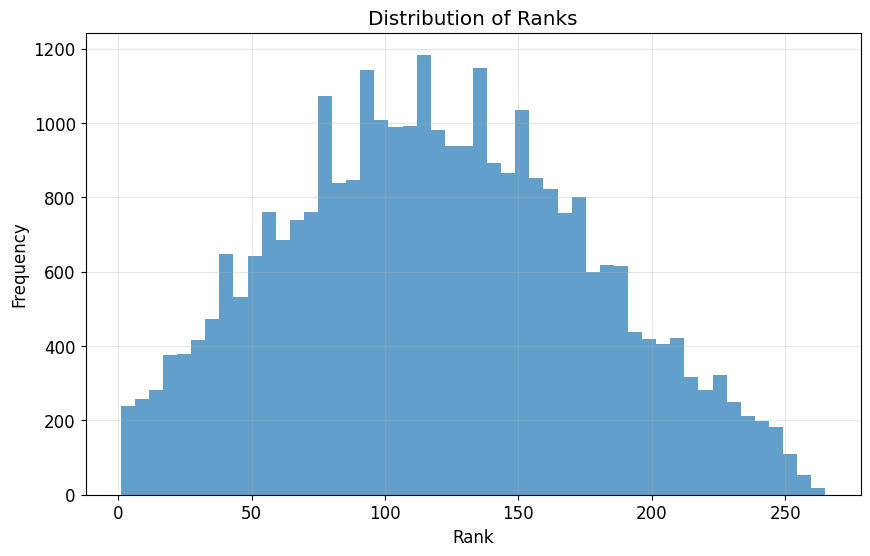

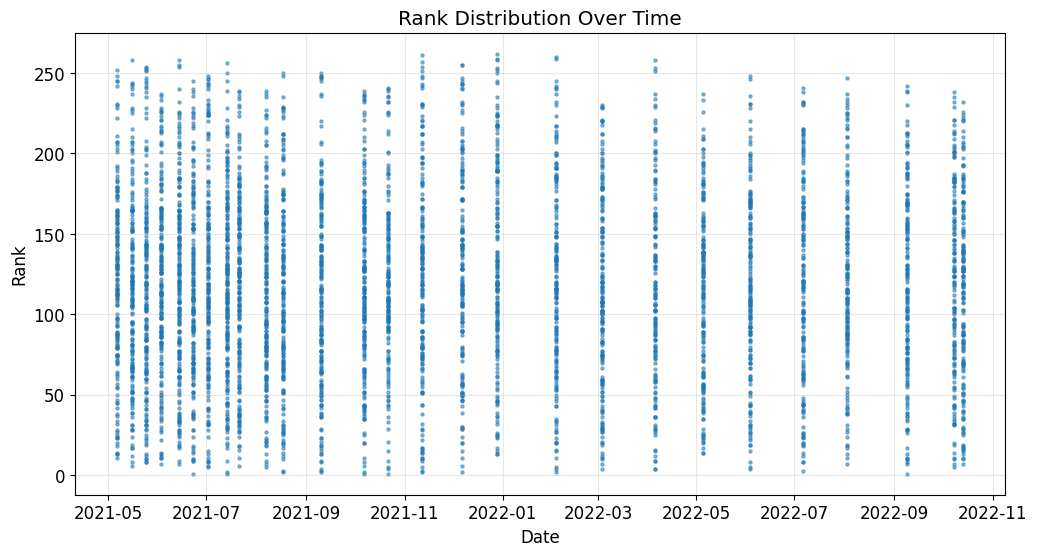

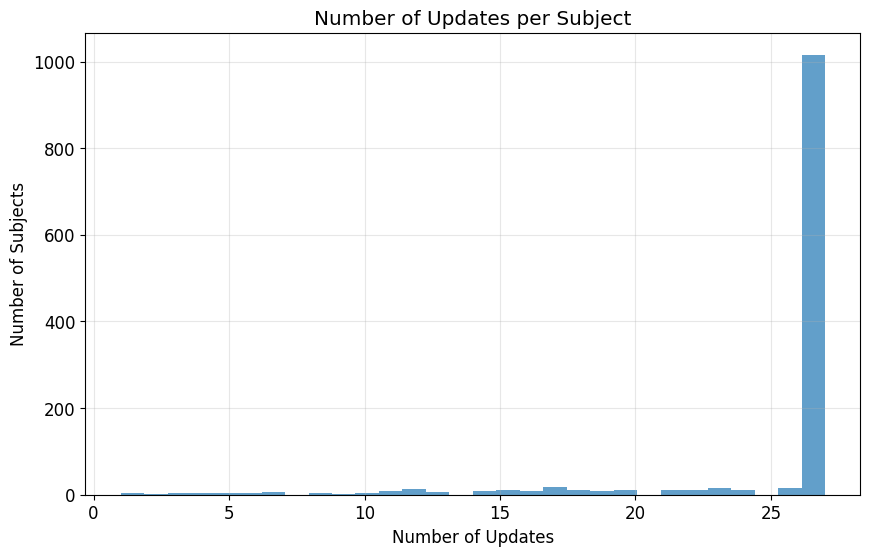


Analyzing factor patterns...
Number of unique factors: 17
Factors: ['Factor1', 'Factor10', 'Factor11', 'Factor12', 'Factor13', 'Factor14', 'Factor15', 'Factor16', 'Factor17', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6', 'Factor7', 'Factor8', 'Factor9']

Factor occurrence frequency:
Factor16: 30767 occurrences
Factor8: 30767 occurrences
Factor5: 30767 occurrences
Factor10: 30767 occurrences
Factor2: 30767 occurrences


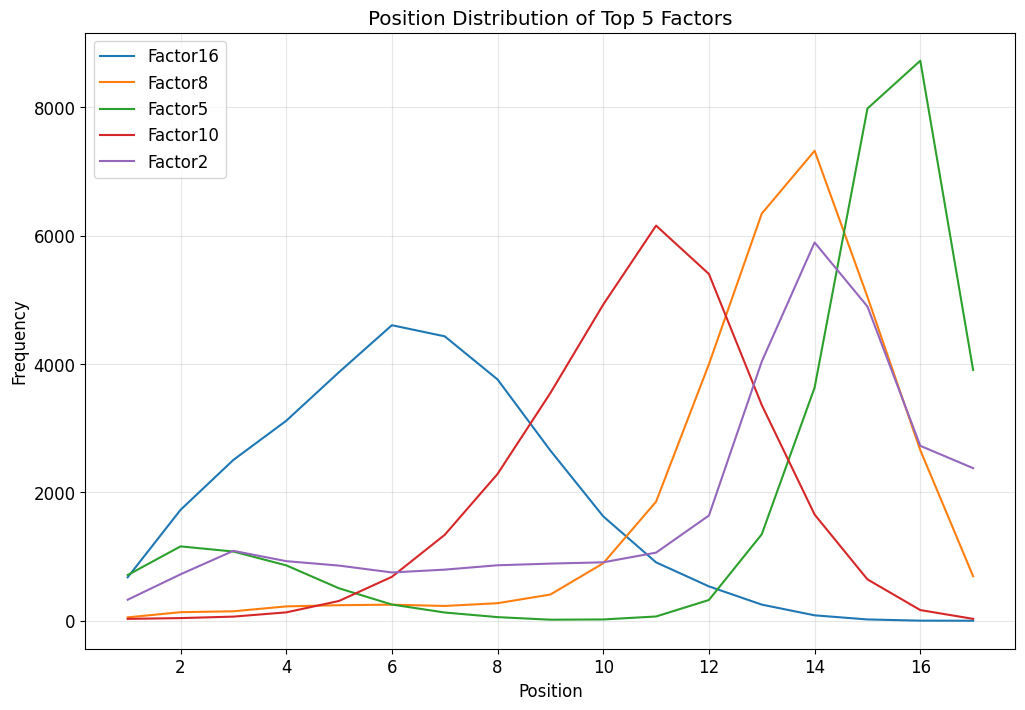


Top 10 factor-position combinations with lowest average rank (highest risk):
    Factor_Position    AvgRank    Factor  Position
278  Factor12_Pos17  27.000000  Factor12        17
257  Factor14_Pos16  32.000000  Factor14        16
284  Factor13_Pos17  38.235294  Factor13        17
266  Factor17_Pos16  45.852941  Factor17        16
141    Factor3_Pos9  48.409091   Factor3         9
286  Factor10_Pos17  48.551724  Factor10        17
271  Factor15_Pos16  50.623377  Factor15        16
288  Factor15_Pos17  55.625000  Factor15        17
273   Factor9_Pos17  57.722222   Factor9        17
269  Factor10_Pos16  58.512048  Factor10        16


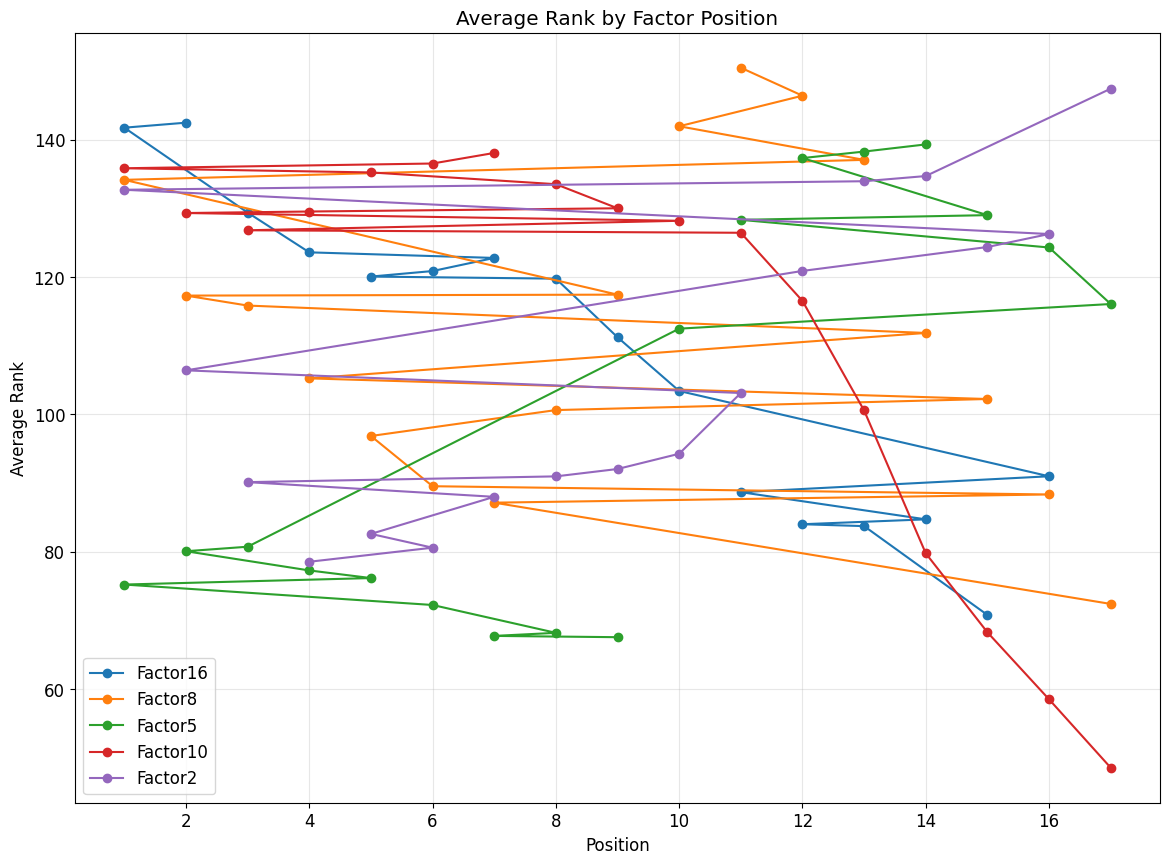

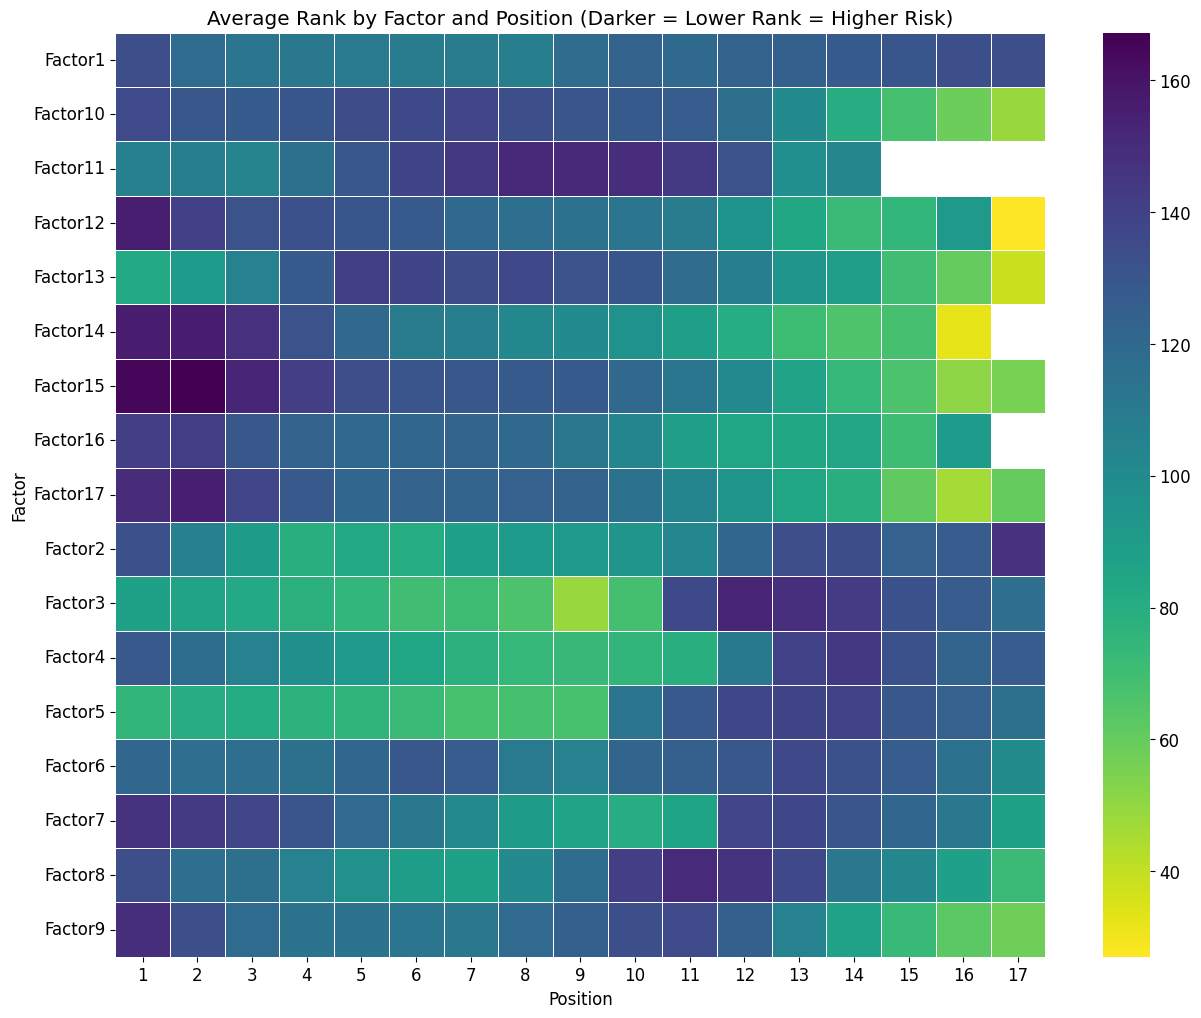


Preprocessing data...
Performing one-hot encoding for factors...
Adding factor frequency and position features...
Adding time-based features...
Processed DataFrame shape: (30767, 353)


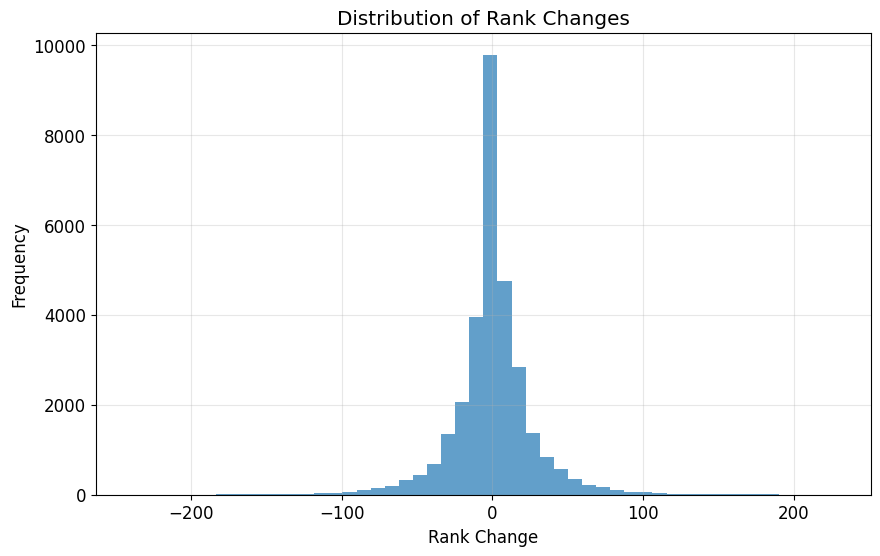

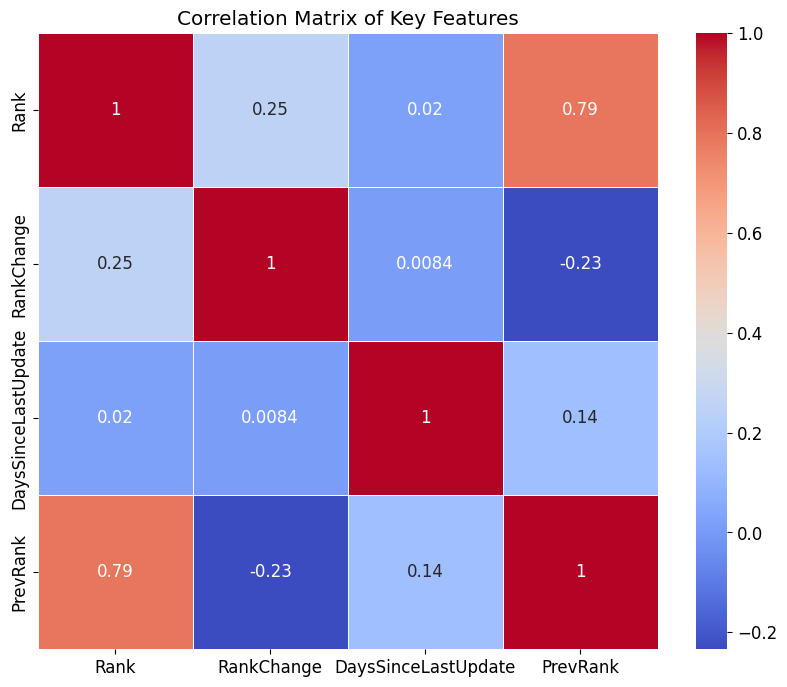


Preparing data for modeling...
Training on data before 2022-06-03 07:46:00
Testing on data on or after 2022-06-03 07:46:00
Training set: 24236 samples
Test set: 6531 samples
['DaysSinceStart', 'Factor16_Pos1', 'Factor9_Pos1', 'Factor14_Pos1', 'Factor4_Pos1', 'Factor11_Pos1', 'Factor3_Pos1', 'Factor12_Pos1', 'Factor7_Pos1', 'Factor1_Pos1', 'Factor8_Pos1', 'Factor6_Pos1', 'Factor17_Pos1', 'Factor13_Pos1', 'Factor2_Pos1', 'Factor10_Pos1', 'Factor5_Pos1', 'Factor15_Pos1', 'Factor16_Pos2', 'Factor9_Pos2', 'Factor14_Pos2', 'Factor4_Pos2', 'Factor11_Pos2', 'Factor3_Pos2', 'Factor12_Pos2', 'Factor7_Pos2', 'Factor1_Pos2', 'Factor8_Pos2', 'Factor6_Pos2', 'Factor17_Pos2', 'Factor13_Pos2', 'Factor2_Pos2', 'Factor10_Pos2', 'Factor5_Pos2', 'Factor15_Pos2', 'Factor16_Pos3', 'Factor9_Pos3', 'Factor14_Pos3', 'Factor4_Pos3', 'Factor11_Pos3', 'Factor3_Pos3', 'Factor12_Pos3', 'Factor7_Pos3', 'Factor1_Pos3', 'Factor8_Pos3', 'Factor6_Pos3', 'Factor17_Pos3', 'Factor13_Pos3', 'Factor2_Pos3', 'Factor10_Pos3',

In [79]:
# Load and explore data
df = load_and_explore_data('Rank.csv')

# Analyze factor patterns
all_factors = analyze_factor_patterns(df)

# Preprocess data
processed_df = preprocess_data(df, all_factors)

# Prepare for modeling
X_train, X_test, y_train, y_test, feature_cols, tscv = prepare_for_modeling(processed_df)


In [80]:
import csv

filename = 'data_cleaned_encoded.csv'

with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(df)

 ## Hyperparameter Tuning (Optional)

 Note: Tuning can be time-consuming. Set tune_models = True to run hyperparameter tuning or False to skip.

In [ ]:
# Set to True to run hyperparameter tuning or False to skip
tune_models = True

if tune_models:
    # Tune Random Forest model with 10 iterations
    rf_tuned = tune_random_forest(X_train, y_train, tscv, n_iter=10)
    
    # Tune Gradient Boosting model with 10 iterations
    gb_tuned = tune_gradient_boosting(X_train, y_train, tscv, n_iter=10)
    
    # Tune LightGBM model with 10 iterations
    lgbm_tuned = tune_lightgbm(X_train, y_train, tscv, n_iter=10)
    
    # Tune XGBoost model with 10 iterations
    xgb_tuned = tune_xgboost(X_train, y_train, tscv, n_iter=10)
else:
    # Use default models
    rf_tuned = RandomForestRegressor(n_estimators=100, random_state=42)
    gb_tuned = GradientBoostingRegressor(n_estimators=100, random_state=42)
    lgbm_tuned = lgbm.LGBMRegressor(n_estimators=100, random_state=42)
    xgb_tuned = xgb.XGBRegressor(n_estimators=100, random_state=42)



Tuning Random Forest hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuning completed in 561.24 seconds
Best parameters: {'max_depth': 37, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 104}
Best MAE: 3.35

Tuning Gradient Boosting hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


 ## Model Training and Evaluation - Random Forest


Training Random Forest...
Training completed in 137.51 seconds

Random Forest Performance Metrics:
MAE: 31.72
RMSE: 40.66
R²: 0.4876
Accuracy within 5 ranks: 9.68%
Accuracy within 10 ranks: 20.27%
Accuracy within 20 ranks: 39.76%


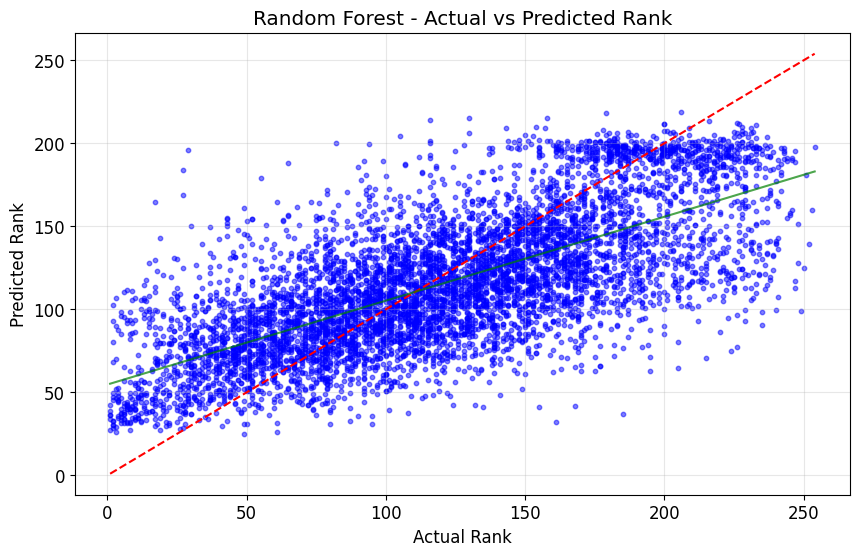

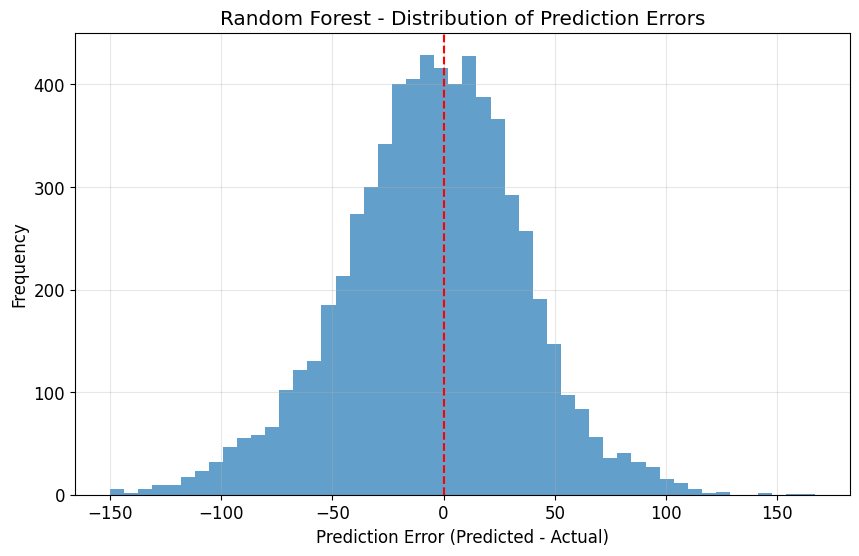

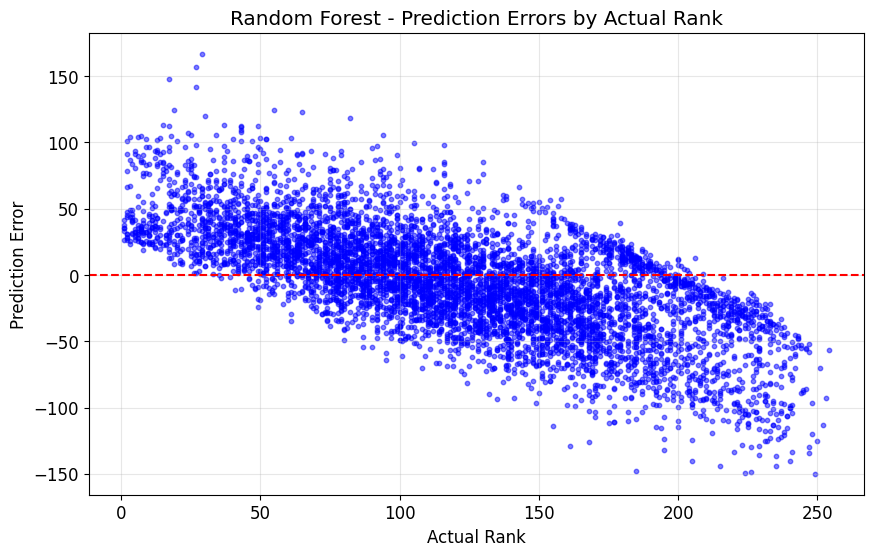

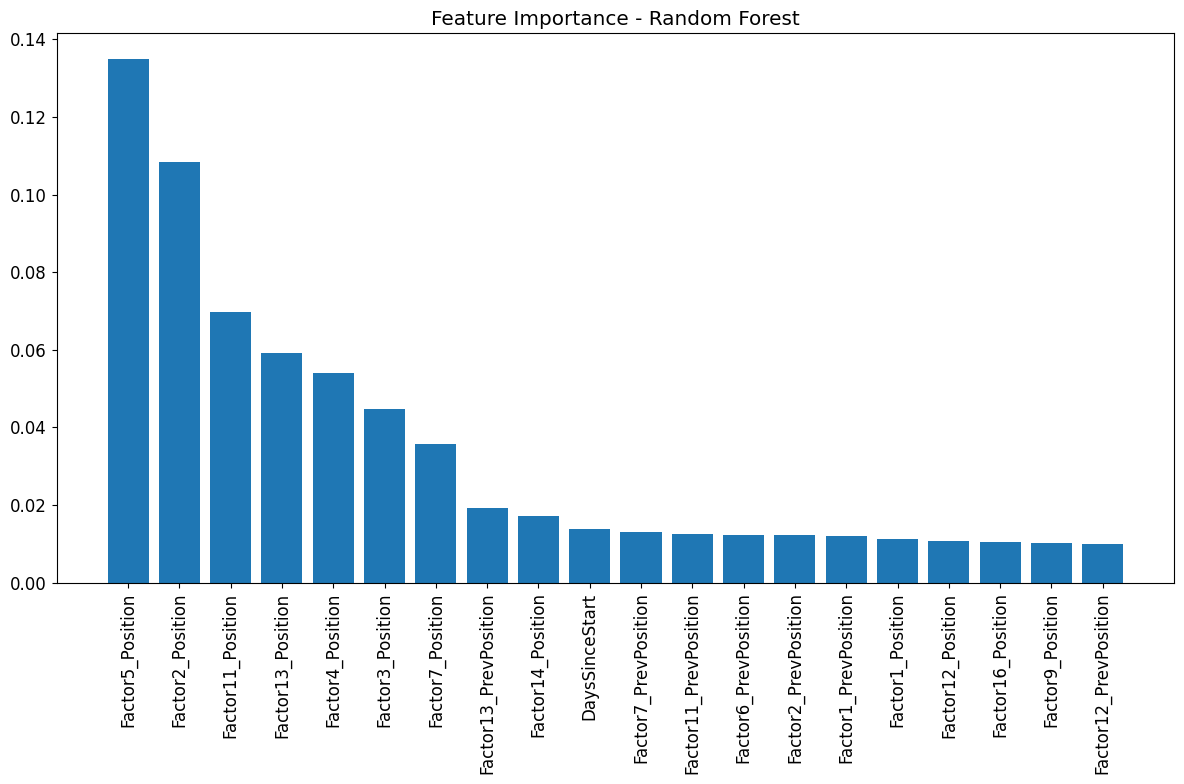

In [ ]:
# Train and evaluate Random Forest model
rf_metrics = train_and_evaluate_model(rf_tuned, "Random Forest", X_train, X_test, y_train, y_test, feature_cols)


 ## Model Training and Evaluation - Gradient Boosting


Training Gradient Boosting...
Training completed in 134.25 seconds

Gradient Boosting Performance Metrics:
MAE: 31.10
RMSE: 40.32
R²: 0.4959
Accuracy within 5 ranks: 10.53%
Accuracy within 10 ranks: 20.95%
Accuracy within 20 ranks: 41.66%


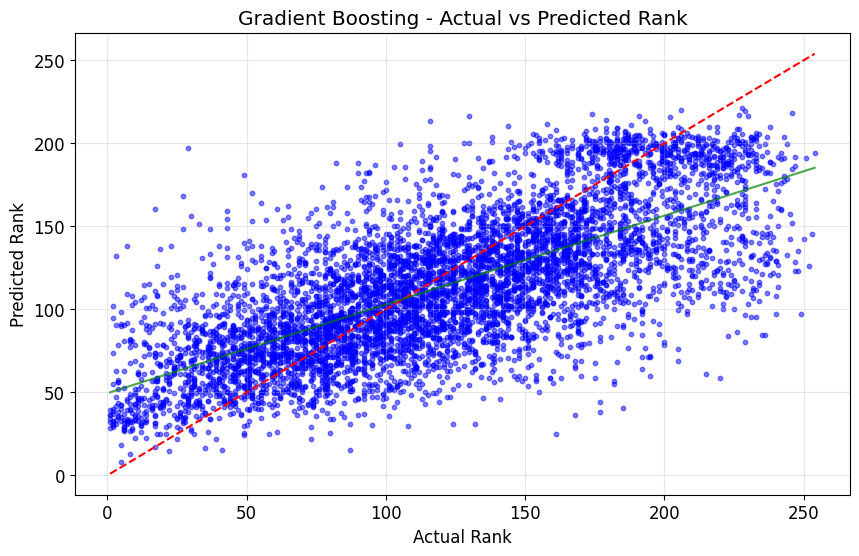

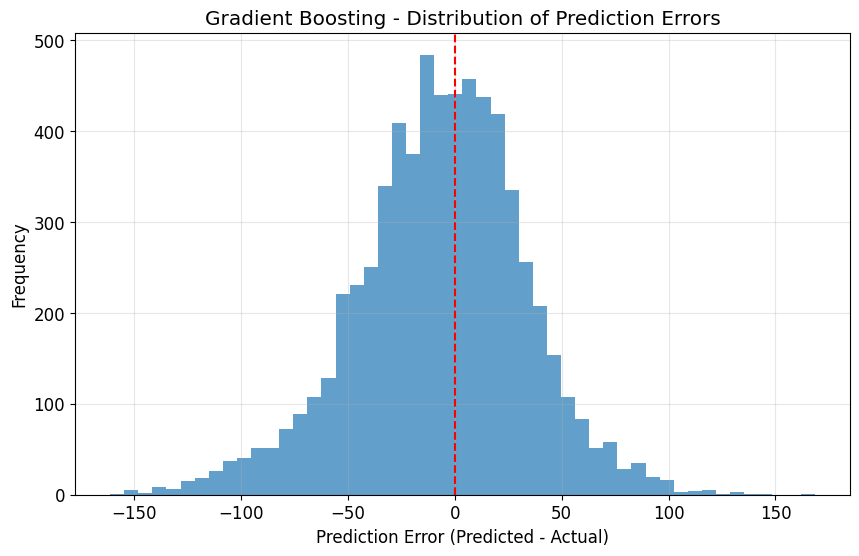

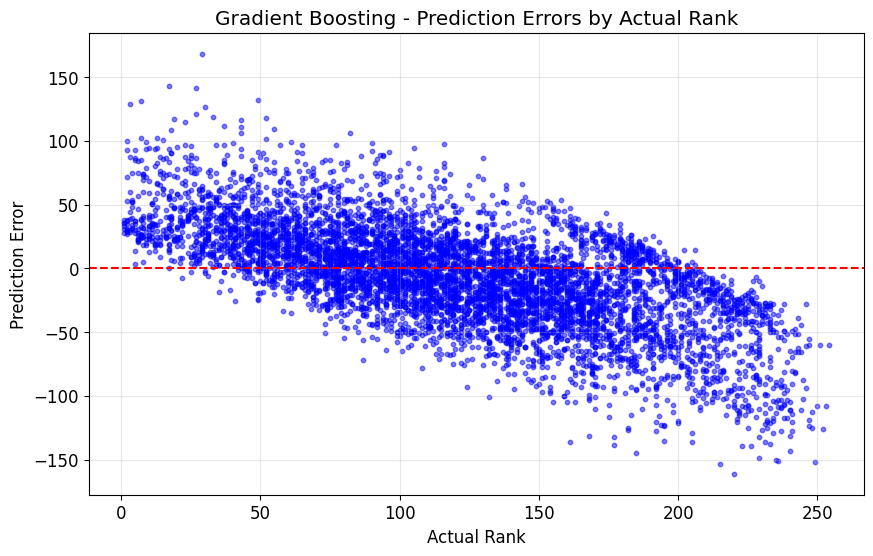

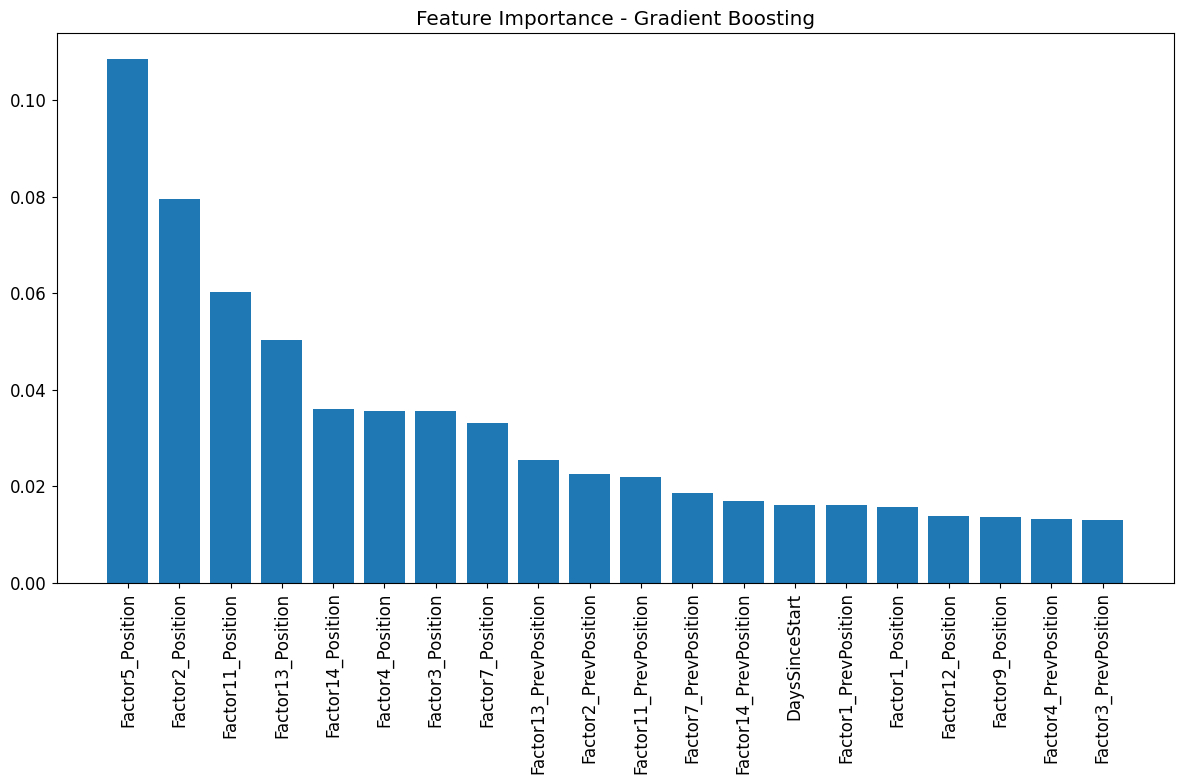

In [ ]:
# Train and evaluate Gradient Boosting model
gb_metrics = train_and_evaluate_model(gb_tuned, "Gradient Boosting", X_train, X_test, y_train, y_test, feature_cols)


 ## Model Training and Evaluation - LightGBM


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 24236, number of used features: 321
[LightGBM] [Info] Start training from score 119.544892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

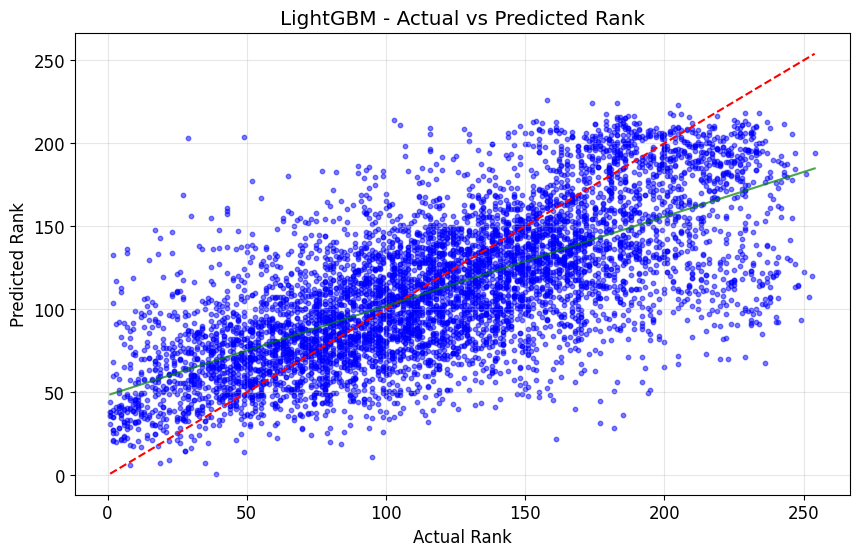

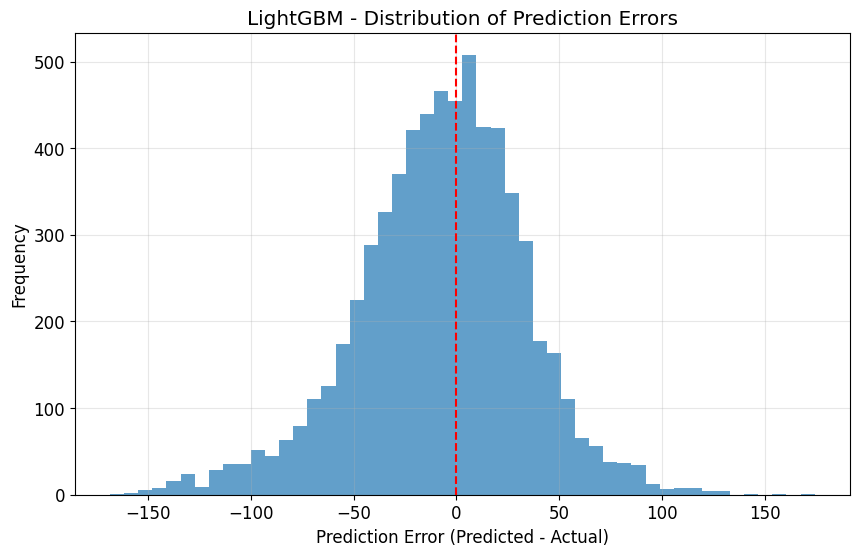

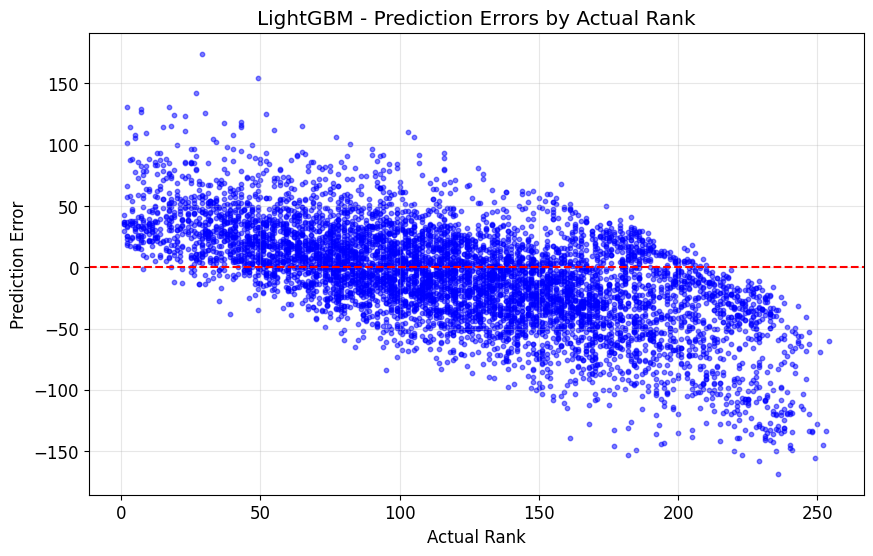

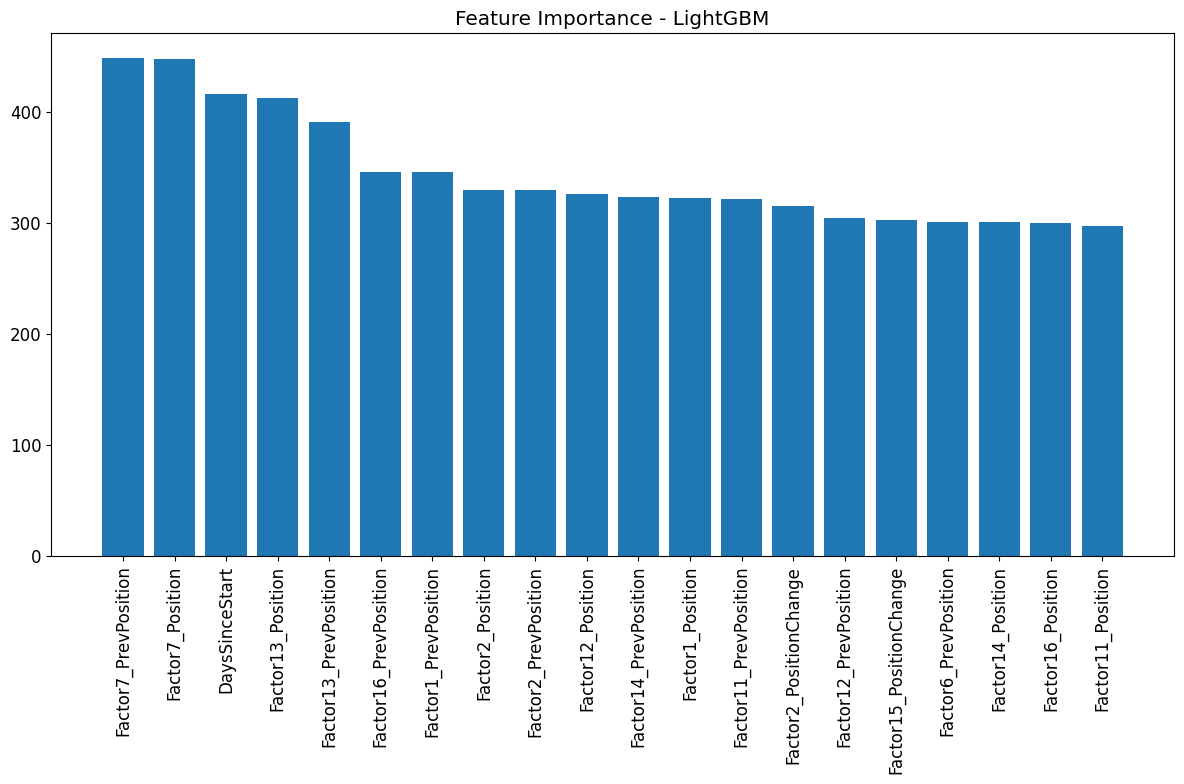

In [ ]:
# Train and evaluate LightGBM model
lgbm_metrics = train_and_evaluate_model(lgbm_tuned, "LightGBM", X_train, X_test, y_train, y_test, feature_cols)


## Mord

In [54]:
# %% [markdown]
# ## Model Training and Evaluation - Ordinal Regression (Mord)
# The mord package implements ordinal regression models specifically designed for ordinal target variables like our rank.

# %%
# Import the necessary mord package
import mord
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder

# %% [markdown]
# ### Preprocessing for Mord Model
# Mord requires target values to be consecutive integers starting from 0 with no gaps.

# %%
# Create a function to remap ranks to a continuous sequence
def preprocess_for_mord(y_train, y_test):
    """
    Preprocess target values for mord by remapping them to a continuous sequence.
    
    Args:
        y_train: Training target values
        y_test: Test target values
        
    Returns:
        y_train_mord: Processed training targets
        y_test_mord: Processed test targets
        label_encoder: Fitted LabelEncoder for inverse transformation
    """
    print("Preprocessing rank values for Mord...")
    
    # Combine train and test to fit the encoder on all possible values
    y_combined = pd.concat([y_train, y_test])
    
    # Use LabelEncoder to transform ranks to a continuous sequence starting from 0
    label_encoder = LabelEncoder()
    label_encoder.fit(y_combined)
    
    # Transform train and test sets
    y_train_mord = pd.Series(label_encoder.transform(y_train), index=y_train.index)
    y_test_mord = pd.Series(label_encoder.transform(y_test), index=y_test.index)
    
    # Check that we have a continuous sequence
    unique_train = np.sort(pd.unique(y_train_mord))
    unique_test = np.sort(pd.unique(y_test_mord))
    
    print(f"Original rank range: [{y_combined.min()}, {y_combined.max()}] with {y_combined.nunique()} unique values")
    print(f"Transformed rank range: [0, {max(unique_train.max(), unique_test.max())}] with {len(label_encoder.classes_)} classes")
    
    return y_train_mord, y_test_mord, label_encoder

# Preprocess the target values for mord
y_train_mord, y_test_mord, rank_encoder = preprocess_for_mord(y_train, y_test)

# %% [markdown]
# ### Hyperparameter Tuning for Mord LogisticIT Model

# %%
def tune_mord_logistic(X_train, y_train, X_val, y_val):
    """
    Tune the alpha parameter for Mord's LogisticIT model
    
    Args:
        X_train: Training features
        y_train: Training target (already encoded for mord)
        X_val: Validation features
        y_val: Validation target (already encoded for mord)
        
    Returns:
        Tuned model and best alpha
    """
    print("\nTuning alpha for Mord LogisticIT...")
    
    # List of alpha values to try
    alphas = [1.0] # 0.01, 0.1, 1.0, 10.0, 50.0, 100.0]
    best_alpha = None
    best_mae = float("inf")
    best_model = None
    
    for alpha_val in alphas:
        # Train the model
        print(f"  Testing alpha={alpha_val}")
        start_time = time.time()
        
        model_temp = mord.LogisticIT(alpha=alpha_val)
        model_temp.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred_encoded = model_temp.predict(X_val)
        
        # Convert predictions back to original rank scale for evaluation
        y_pred_temp = rank_encoder.inverse_transform(y_pred_encoded)
        
        mae_temp = mean_absolute_error(rank_encoder.inverse_transform(y_val), y_pred_temp)
        
        train_time = time.time() - start_time
        print(f"  alpha={alpha_val:<5} => Validation MAE={mae_temp:.2f}, Time={train_time:.2f}s")
        
        # Keep track of the best model
        if mae_temp < best_mae:
            best_mae = mae_temp
            best_alpha = alpha_val
            best_model = model_temp
    
    print(f"\nBest alpha: {best_alpha} with MAE = {best_mae:.2f}")
    
    return best_model, best_alpha

# Create a validation set from the training data for tuning
# We use a time-based split similar to the test set creation
train_timestamps = X_train.index.get_level_values('UpdateDT') if isinstance(X_train.index, pd.MultiIndex) else pd.Series(X_train.index)
cutoff_date_val = train_timestamps.quantile(0.80)

# Split training data into train and validation
if isinstance(X_train.index, pd.MultiIndex):
    tuning_train_mask = X_train.index.get_level_values('UpdateDT') <= cutoff_date_val
else:
    tuning_train_mask = train_timestamps <= cutoff_date_val

X_tune_train = X_train[tuning_train_mask]
y_tune_train = y_train_mord[tuning_train_mask]
X_tune_val = X_train[~tuning_train_mask]
y_tune_val = y_train_mord[~tuning_train_mask]

# Use a default alpha if tuning is disabled
if tune_models:
    mord_tuned, best_alpha = tune_mord_logistic(X_tune_train, y_tune_train, X_tune_val, y_tune_val)
else:
    # Use alpha=50 as in the sample code
    best_alpha = 50.0
    mord_tuned = mord.LogisticIT(alpha=best_alpha)

# %% [markdown]
# ### Train and Evaluate Mord LogisticIT Model

# %%
def train_and_evaluate_mord_model(model, X_train, y_train_mord, X_test, y_test_mord, y_test_original, 
                                 feature_cols, rank_encoder, name="Mord LogisticIT"):
    """
    Train and evaluate a Mord LogisticIT model
    
    Args:
        model: Mord model instance
        X_train: Training features
        y_train_mord: Training target (encoded for mord)
        X_test: Test features
        y_test_mord: Test target (encoded for mord)
        y_test_original: Original test target for evaluation
        feature_cols: List of feature columns
        rank_encoder: LabelEncoder for converting back to original ranks
        name: Model name
        
    Returns:
        Dictionary with model scores and the trained model
    """
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train_mord)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Make predictions (encoded)
    y_pred_encoded = model.predict(X_test)
    
    # Convert predictions back to original rank scale
    y_pred = rank_encoder.inverse_transform(y_pred_encoded)
    
    # Evaluate model using our standard metrics
    metrics = evaluate_model(y_test_original, y_pred, name)
    metrics['train_time'] = train_time
    metrics['model'] = model
    
    # Add Spearman correlation (rank correlation)
    spearman_corr, _ = spearmanr(y_pred, y_test_original)
    metrics['spearman'] = spearman_corr
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original, y_pred, alpha=0.5, s=10, c='blue')
    min_val = min(y_test_original.min(), min(y_pred))
    max_val = max(y_test_original.max(), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add regression line
    z = np.polyfit(y_test_original, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(np.sort(y_test_original), p(np.sort(y_test_original)), "g-", alpha=0.7)
    
    plt.xlabel('Actual Rank')
    plt.ylabel('Predicted Rank')
    plt.title(f'{name} - Actual vs Predicted Rank')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot prediction errors
    errors = y_pred - y_test_original
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error (Predicted - Actual)')
    plt.ylabel('Frequency')
    plt.title(f'{name} - Distribution of Prediction Errors')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Analyze coefficients if available
    if hasattr(model, 'coef_'):
        # Get coefficients
        coef_values = model.coef_.ravel()
        feature_effects = pd.DataFrame({
            "Feature": feature_cols,
            "Coefficient": coef_values
        }).sort_values(by="Coefficient", ascending=False)
        
        # Plot top 20 coefficients
        plt.figure(figsize=(12, 8))
        top_20 = feature_effects.head(20)
        sns.barplot(x="Coefficient", y="Feature", data=top_20, orient="h")
        plt.title(f'Top 20 Coefficients - {name}')
        plt.tight_layout()
        plt.show()
        
        # Extract driver information if possible using regex
        try:
            import re
            def extract_driver(feature_name):
                # Try to extract driver patterns - adjust based on your feature names
                driver_match = re.search(r'(Driver\d+)_', feature_name)
                if driver_match:
                    return driver_match.group(1)
                return "Other"
                
            feature_effects["DriverGroup"] = feature_effects["Feature"].apply(extract_driver)
            
            # Group by driver and sum absolute coefficients
            driver_importance = (
                feature_effects
                .groupby("DriverGroup")["Coefficient"]
                .apply(lambda x: x.abs().sum())  # sum of absolute values
                .reset_index(name="AbsCoeffSum")
            )
            
            # Sort by descending total importance
            driver_importance.sort_values(by="AbsCoeffSum", ascending=False, inplace=True)
            
            # Show top drivers
            plt.figure(figsize=(10, 6))
            top_drivers = driver_importance.head(10)
            sns.barplot(data=top_drivers, x="AbsCoeffSum", y="DriverGroup", orient="h")
            plt.title("Driver Importance (Sum of Absolute Coefficients)")
            plt.xlabel("Sum of |Coefficients|")
            plt.ylabel("Driver")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not extract driver information: {e}")
    
    return metrics

# Train and evaluate the Mord model with the best alpha
mord_metrics = train_and_evaluate_mord_model(
    mord_tuned, 
    X_train, 
    y_train_mord, 
    X_test, 
    y_test_mord, 
    y_test,  # Original y_test for evaluation
    feature_cols, 
    rank_encoder,
    name=f"Mord LogisticIT (alpha={best_alpha})"
)

# %% [markdown]
# ## Updated Model Comparison with Mord

# %%
# Add Mord model to the model scores dictionary
model_scores["Mord LogisticIT"] = mord_metrics

# Compare model performance including Mord
score_df = compare_model_performance(model_scores)

# Find best model based on MAE
best_model_name = score_df.sort_values('MAE').iloc[0]['Model']
best_model = model_scores[best_model_name]['model']

print(f"\nBest model: {best_model_name}")
print(f"MAE: {model_scores[best_model_name]['mae']:.2f}")
print(f"R²: {model_scores[best_model_name]['r2']:.4f}")
if 'spearman' in model_scores[best_model_name]:
    print(f"Spearman Correlation: {model_scores[best_model_name]['spearman']:.4f}")

Preprocessing rank values for Mord...
Original rank range: [1, 265] with 265 unique values
Transformed rank range: [0, 264] with 265 classes


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

 ## Model Training and Evaluation - XGBoost


Training XGBoost...
Training completed in 9.98 seconds

XGBoost Performance Metrics:
MAE: 31.44
RMSE: 40.82
R²: 0.4833
Accuracy within 5 ranks: 10.72%
Accuracy within 10 ranks: 21.57%
Accuracy within 20 ranks: 40.50%


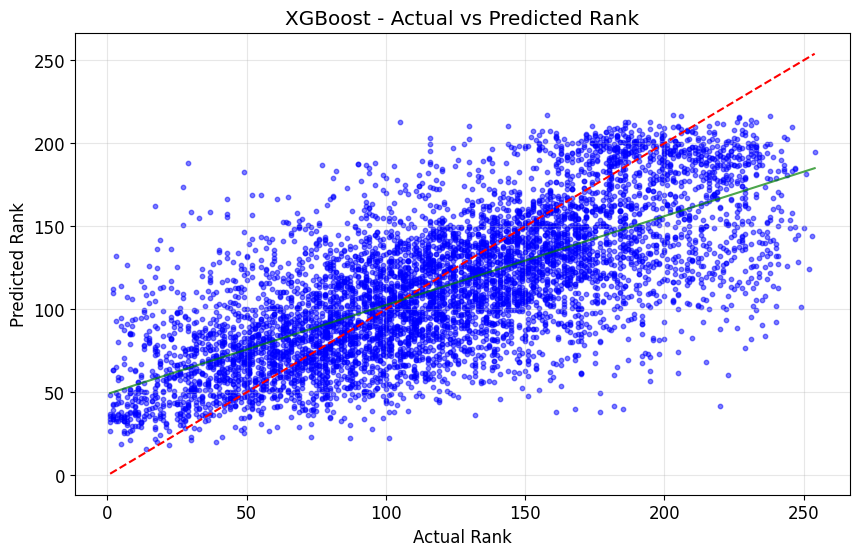

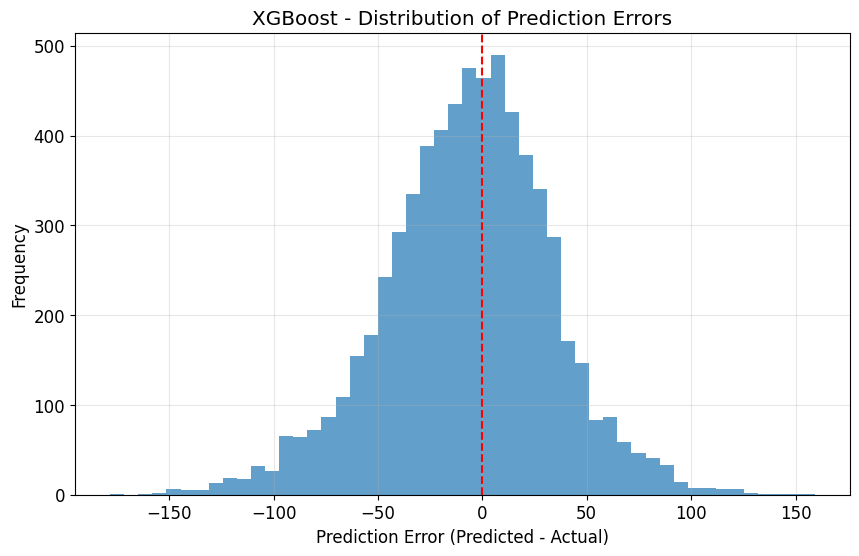

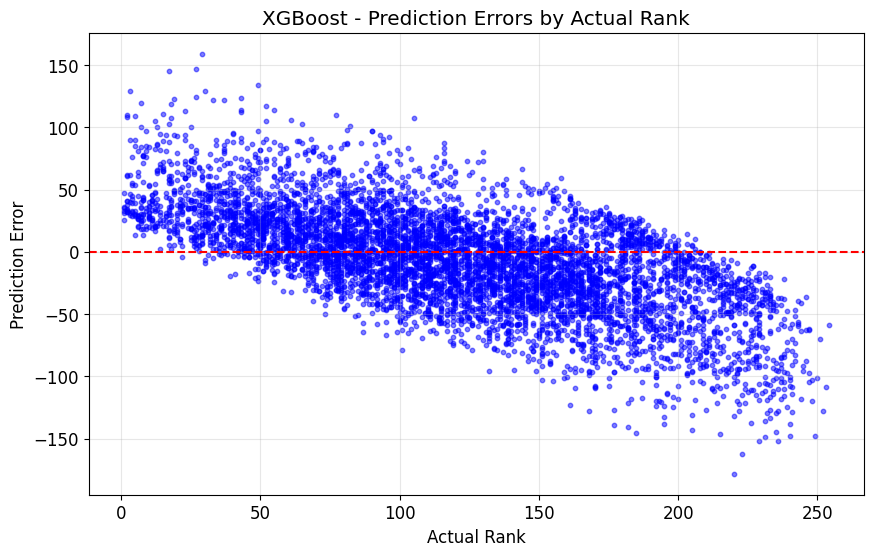

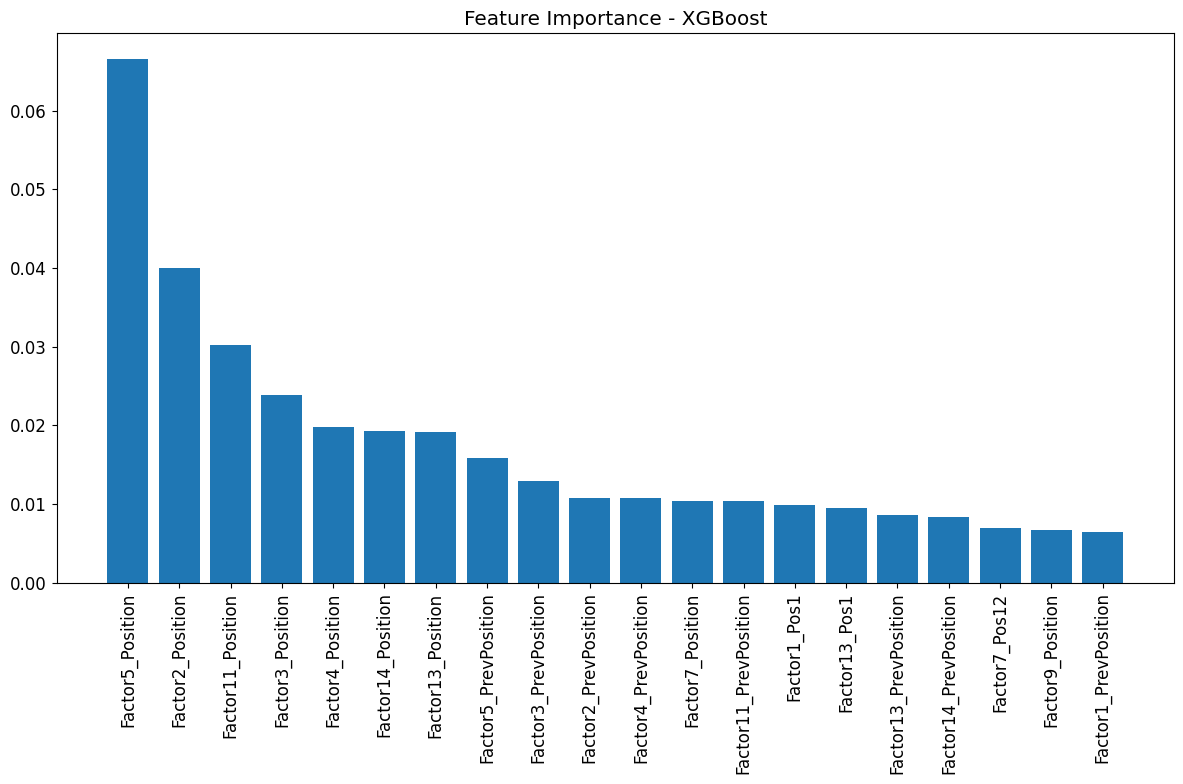

In [29]:
# Train and evaluate XGBoost model
xgb_metrics = train_and_evaluate_model(xgb_tuned, "XGBoost", X_train, X_test, y_train, y_test, feature_cols)


 ## Model Comparison and Selection


Comparing model performance...

Model Performance Summary:
               Model        MAE       RMSE        R²    Acc ≤5   Acc ≤10  \
0      Random Forest  31.724415  40.655362  0.487586  0.096769  0.202725   
1  Gradient Boosting  31.098880  40.323454  0.495918  0.105344  0.209463   
2           LightGBM  31.840246  41.693012  0.461095  0.106875  0.213597   
3            XGBoost  31.441480  40.823089  0.483349  0.107181  0.215740   

    Acc ≤20  Train Time (s)  
0  0.397642      137.509387  
1  0.416628      134.254886  
2  0.407748        4.210752  
3  0.404992        9.979441  


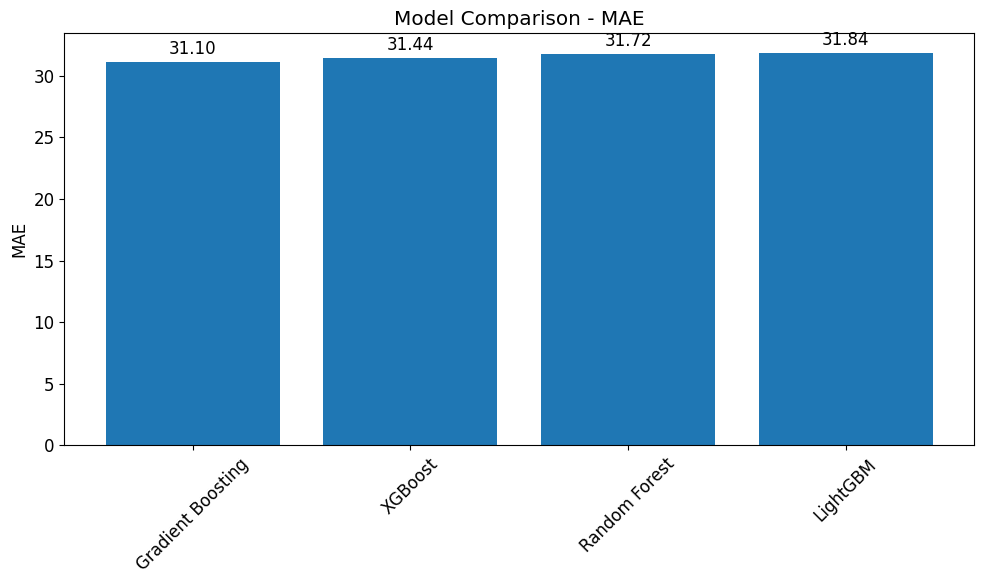

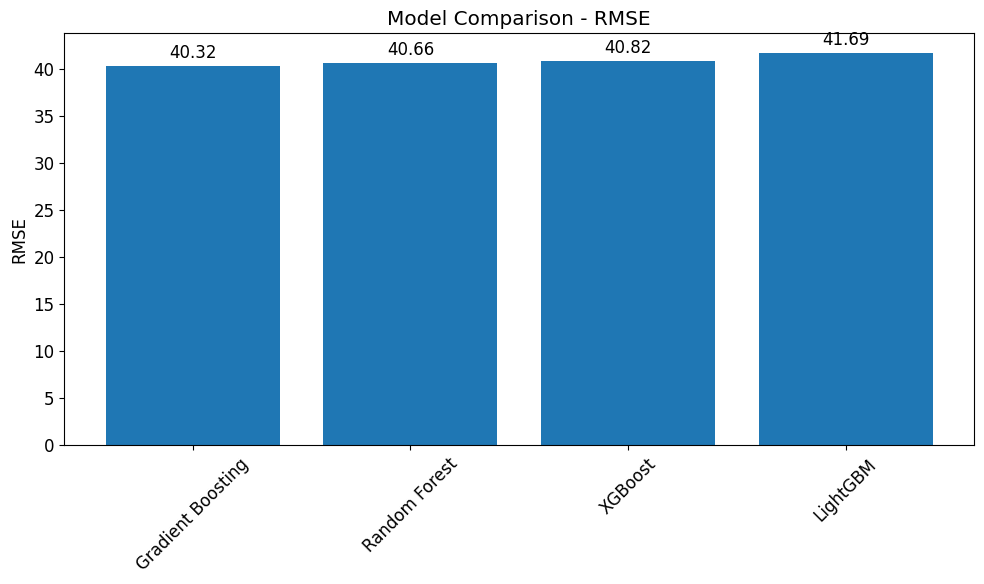

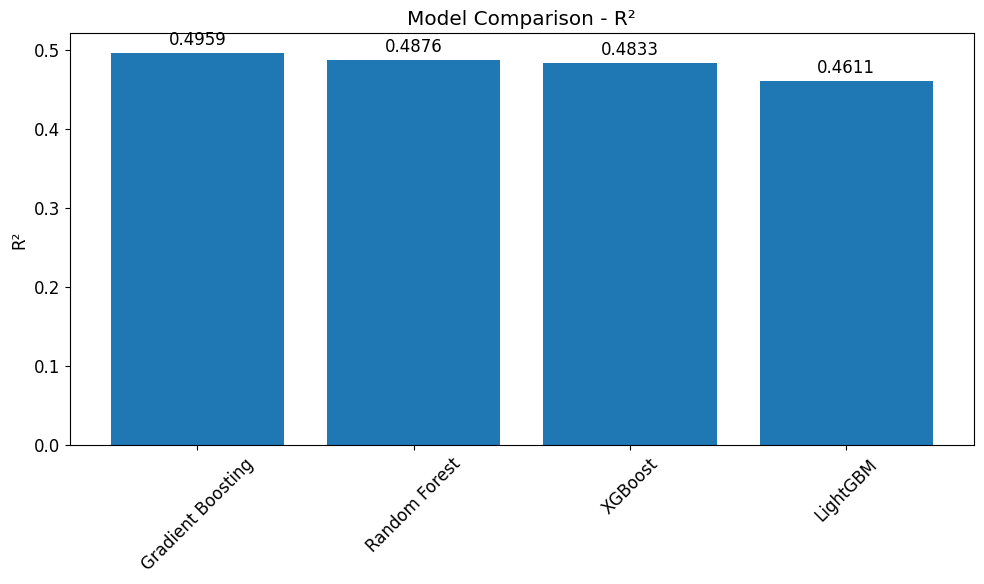

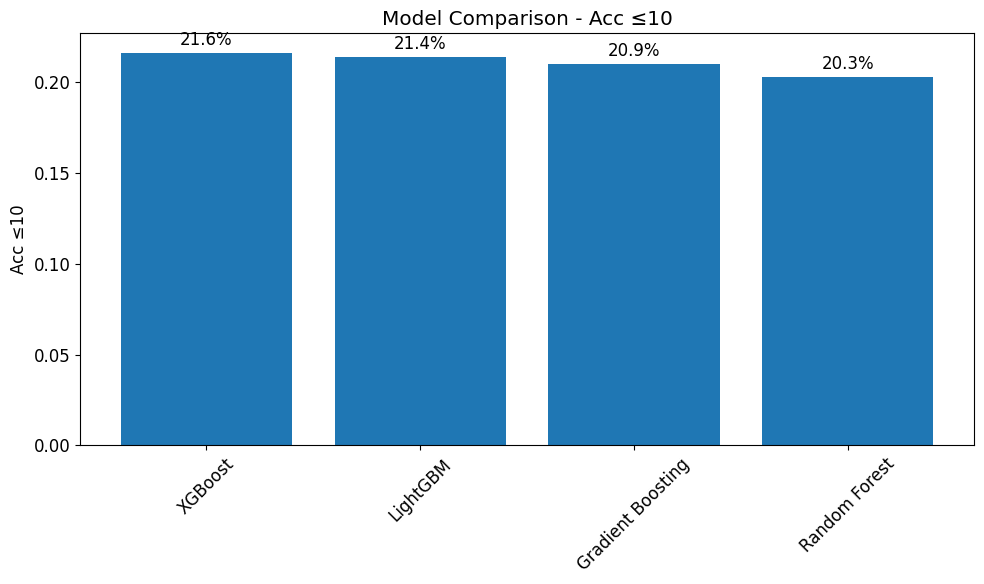

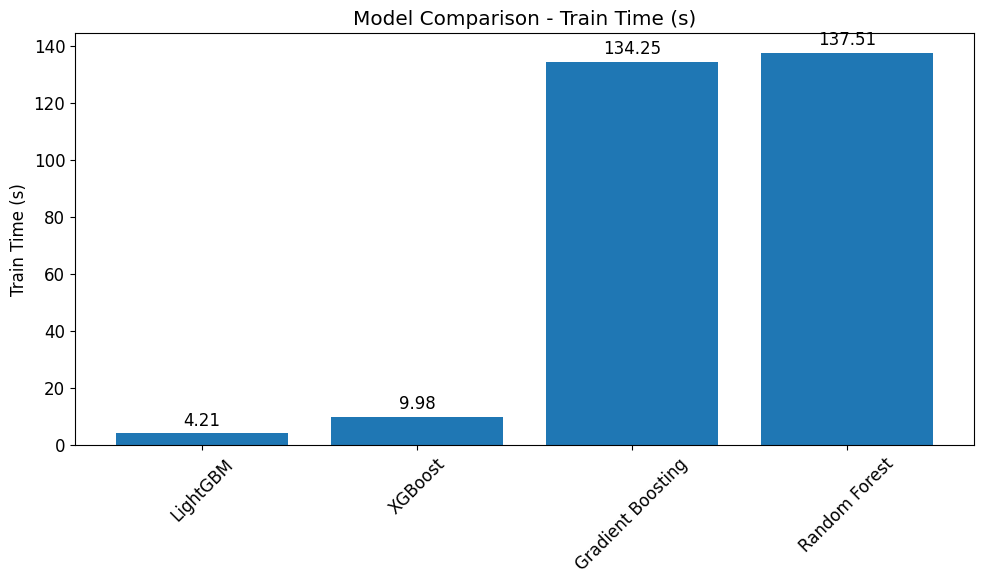

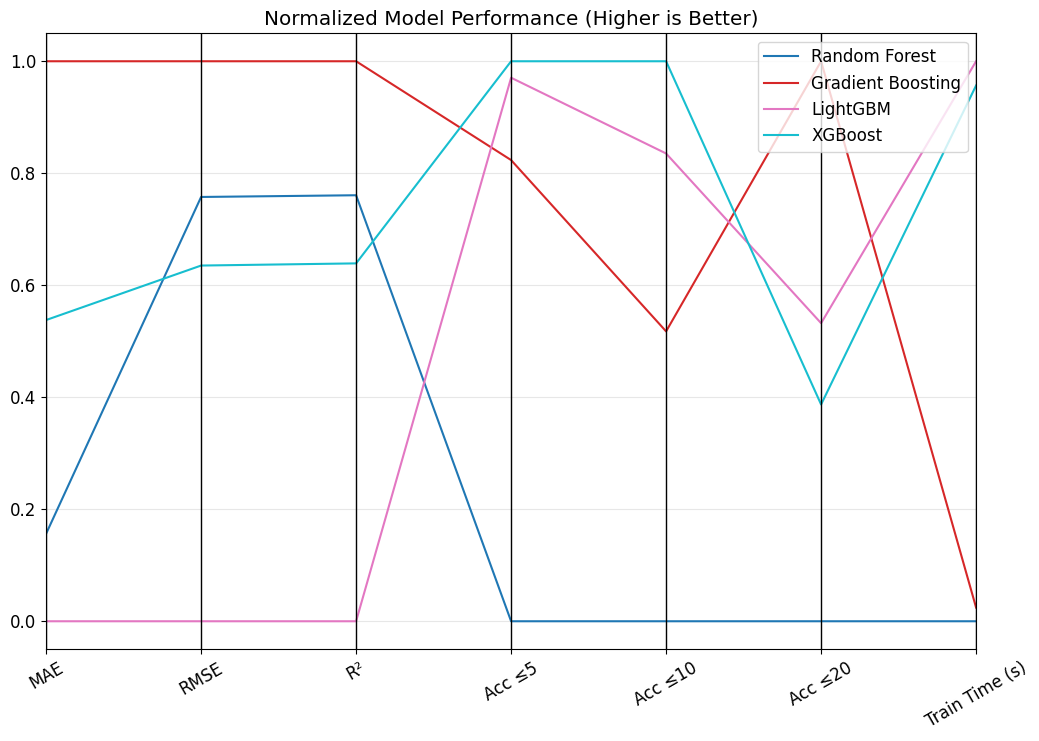


Best model: Gradient Boosting
MAE: 31.10
R²: 0.4959


In [30]:
# Combine all model scores
model_scores = {
    "Random Forest": rf_metrics,
    "Gradient Boosting": gb_metrics,
    "LightGBM": lgbm_metrics,
    "XGBoost": xgb_metrics
}

# Compare model performance
score_df = compare_model_performance(model_scores)

# Find best model based on MAE
best_model_name = score_df.sort_values('MAE').iloc[0]['Model']
best_model = model_scores[best_model_name]['model']

print(f"\nBest model: {best_model_name}")
print(f"MAE: {model_scores[best_model_name]['mae']:.2f}")
print(f"R²: {model_scores[best_model_name]['r2']:.4f}")


 ## Key Driver Identification with Best Model


Identifying key drivers of rank changes...

Top 10 most influential factors:
Factor1: 0.4377
Factor5: 0.1256
Factor2: 0.1155
Factor13: 0.0919
Factor11: 0.0916
Factor7: 0.0668
Factor14: 0.0629
Factor3: 0.0572
Factor4: 0.0571
Factor12: 0.0352


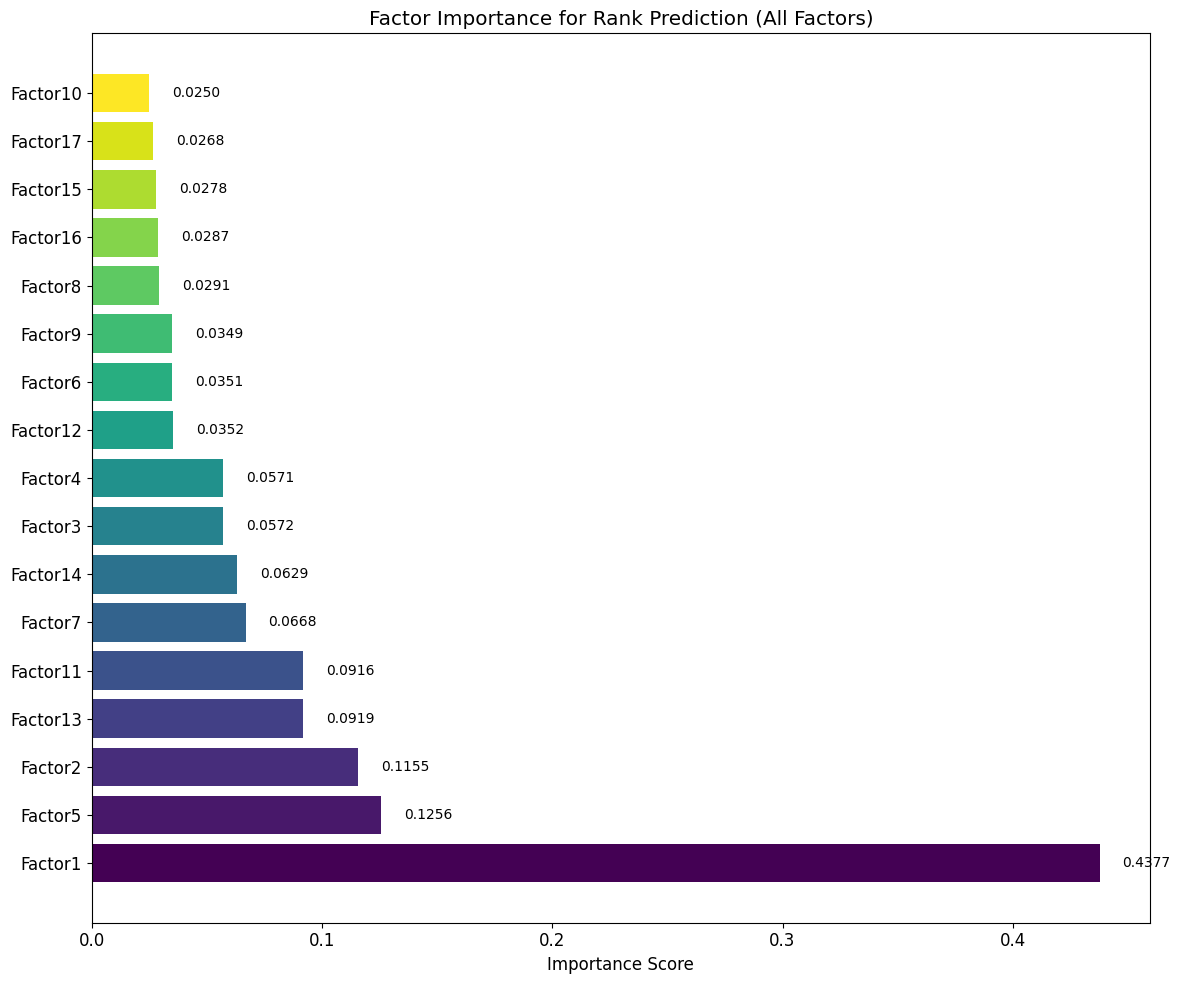

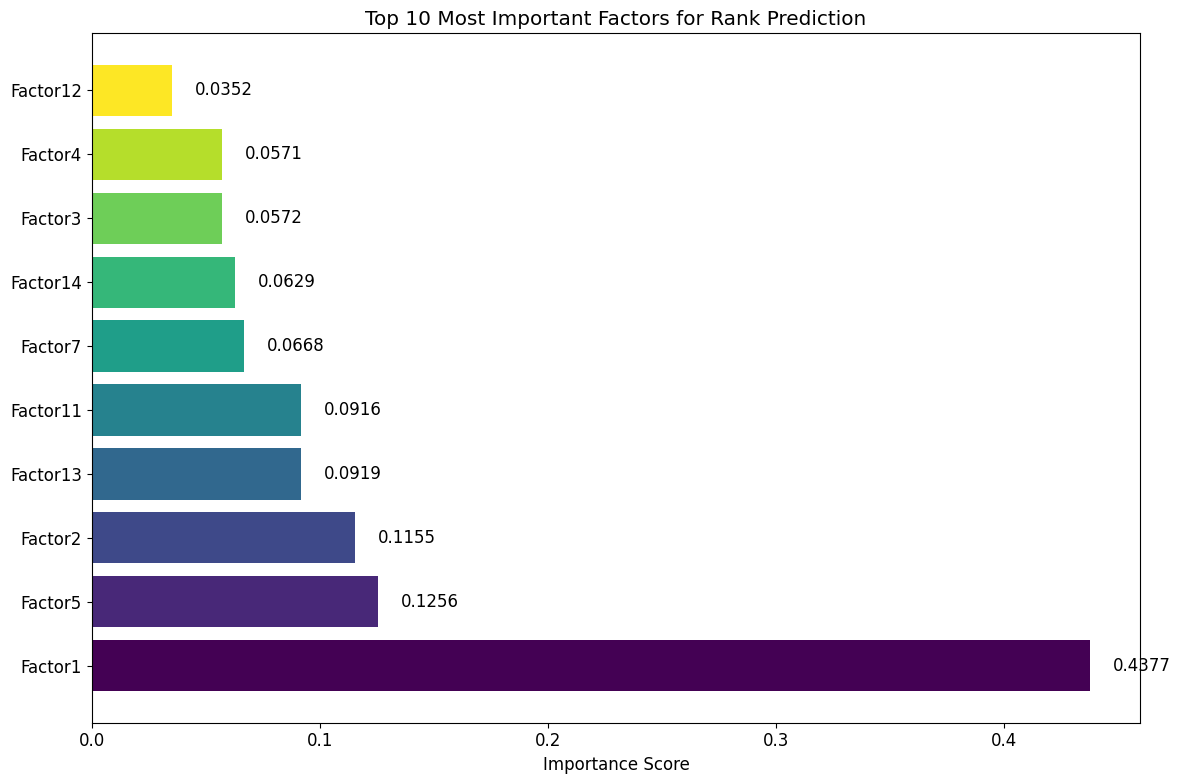

In [31]:
# Identify key drivers with the best model
factor_importance = identify_key_drivers(best_model, feature_cols, all_factors)


 ## Future Rank Forecasting


Forecasting future ranks for 3 periods...


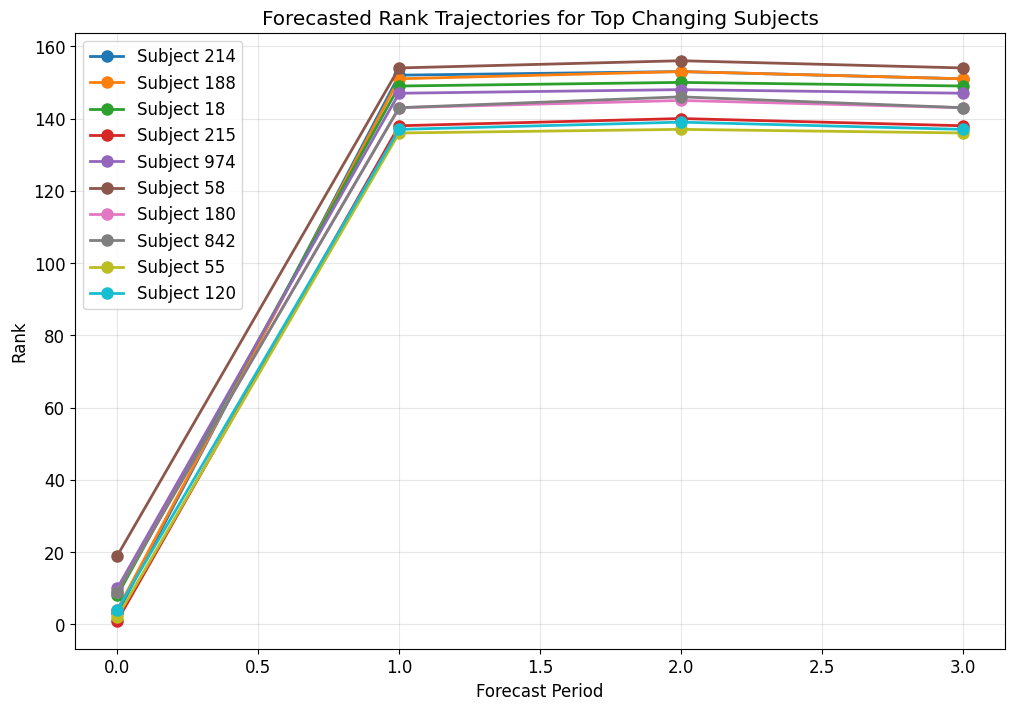

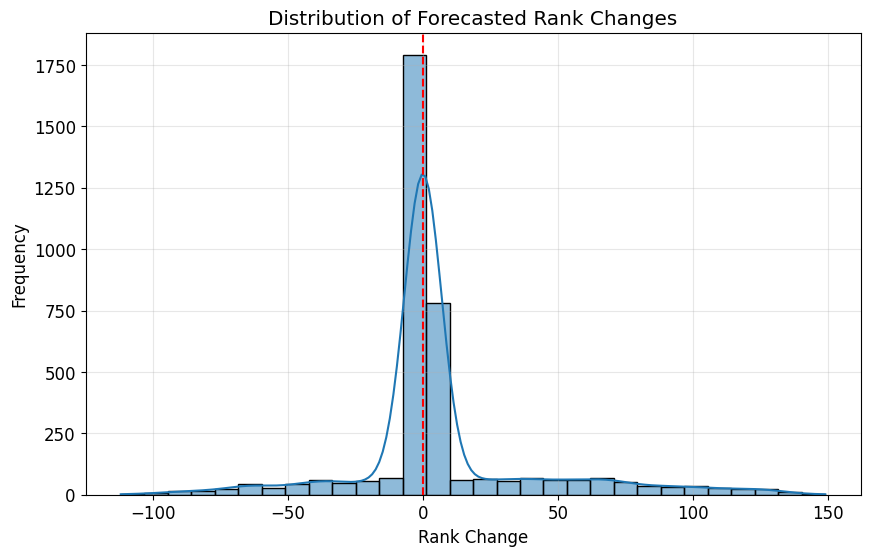

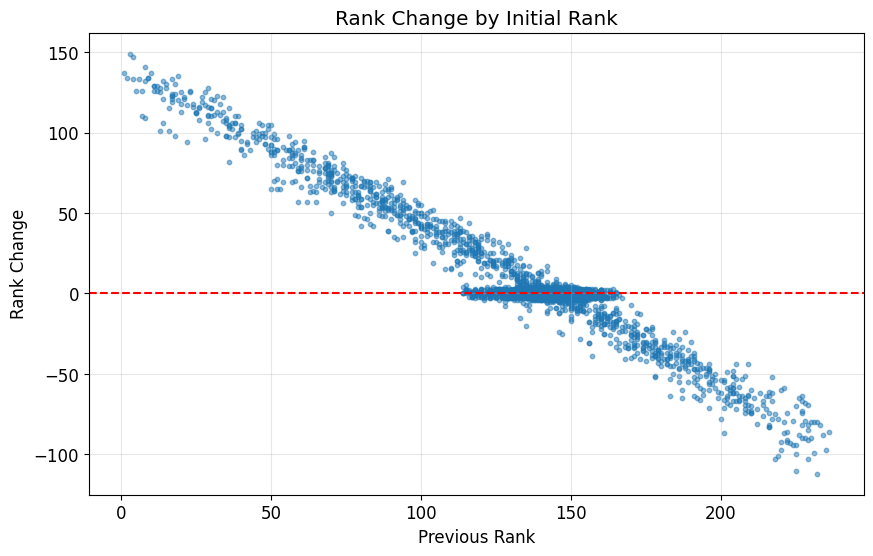

In [32]:
# Forecast future ranks for all subjects (3 periods ahead)
forecast_df = forecast_future_ranks(processed_df, best_model, feature_cols, all_factors, n_periods=3)

# Save forecasts to CSV
forecast_df.to_csv('rank_forecasts.csv', index=False)


 ## Targeted Forecasting for Specific Subjects


Forecasting future ranks for 5 specific subjects over 6 periods...
Found 5 of the 5 requested subjects in the data.
Forecasting for Subject 18, Last Rank: 8
Forecasting for Subject 188, Last Rank: 4
Forecasting for Subject 214, Last Rank: 3
Forecasting for Subject 215, Last Rank: 1
Forecasting for Subject 974, Last Rank: 10


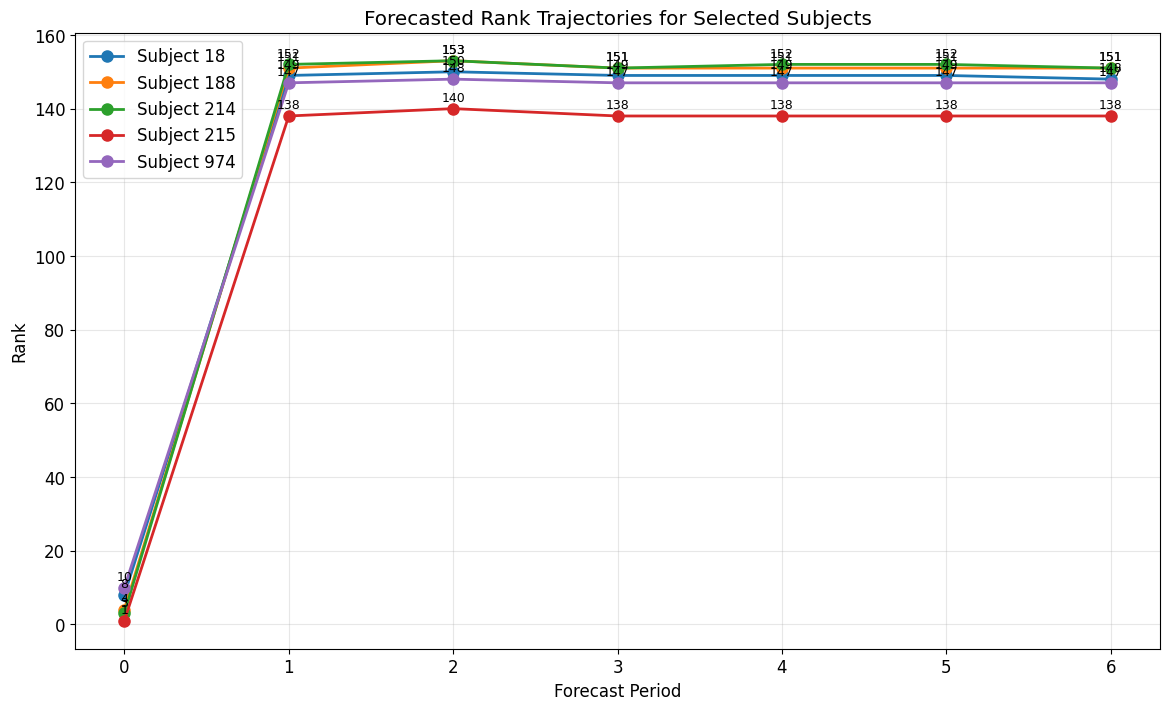


Forecast Summary:
   SubjectID  InitialRank  FinalRank  TotalChange  AvgPerPeriodChange
0         18            8        148          140           23.333333
1        188            4        151          147           24.500000
2        214            3        151          148           24.666667
3        215            1        138          137           22.833333
4        974           10        147          137           22.833333

Forecasting future ranks for 5 specific subjects over 6 periods...
Found 5 of the 5 requested subjects in the data.
Forecasting for Subject 154, Last Rank: 146
Forecasting for Subject 228, Last Rank: 34
Forecasting for Subject 323, Last Rank: 11
Forecasting for Subject 426, Last Rank: 175
Forecasting for Subject 801, Last Rank: 119


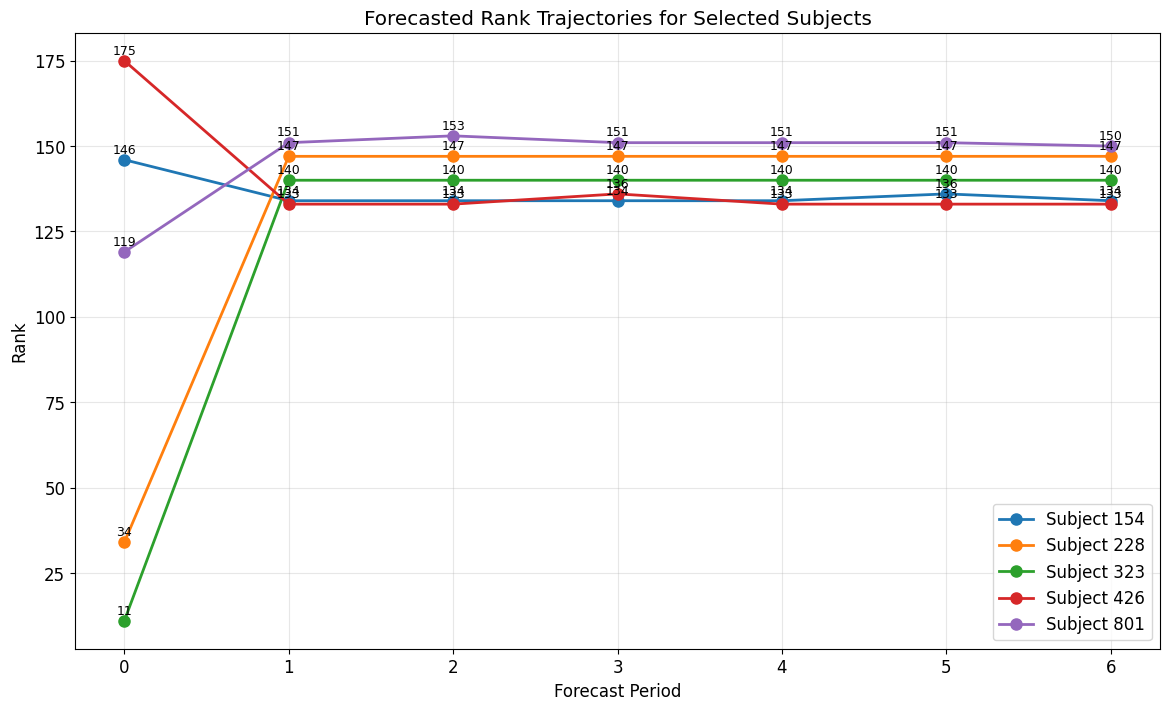


Forecast Summary:
   SubjectID  InitialRank  FinalRank  TotalChange  AvgPerPeriodChange
0        154          146        134          -12           -2.000000
1        228           34        147          113           18.833333
2        323           11        140          129           21.500000
3        426          175        133          -42           -7.000000
4        801          119        150           31            5.166667


In [33]:
# Select a subset of subjects for targeted forecasting
# Choose subjects with the largest changes from the previous forecast
top_changing_subjects = forecast_df.groupby('SubjectID')['RankChange'].sum().abs().sort_values(ascending=False).head(5).index.tolist()

# Forecast 6 periods ahead for these specific subjects
specific_forecasts = forecast_specific_subjects(processed_df, best_model, feature_cols, all_factors, 
                                                subject_ids=top_changing_subjects, n_periods=6)

# Add some random subjects for contrast (if there are enough subjects)
if processed_df['SubjectID'].nunique() > 10:
    # Get random subjects different from the top changing ones
    other_subjects = processed_df['SubjectID'].unique()
    other_subjects = [s for s in other_subjects if s not in top_changing_subjects]
    import random
    random_subjects = random.sample(list(other_subjects), min(5, len(other_subjects)))
    
    # Forecast for random subjects
    random_forecasts = forecast_specific_subjects(processed_df, best_model, feature_cols, all_factors, 
                                                  subject_ids=random_subjects, n_periods=6)

# Alternatively, you can manually specify subjects of interest
# Example: specific_forecasts = forecast_specific_subjects(processed_df, best_model, feature_cols, all_factors, 
#                                                        subject_ids=[1, 50, 100, 200, 500], n_periods=6)


 ## Summary of Findings

In [34]:
# Print summary of analysis
print("="*80)
print("RANK PREDICTION ANALYSIS SUMMARY")
print("="*80)

print("\nBest performing model:")
print(f"- {best_model_name} with MAE: {model_scores[best_model_name]['mae']:.2f}")
print(f"- Accuracy within 10 ranks: {model_scores[best_model_name]['acc_10']:.2%}")

print("\nTop 5 factors influencing rank:")
top_factors = sorted(factor_importance.items(), key=lambda x: x[1], reverse=True)[:5]
for i, (factor, importance) in enumerate(top_factors):
    print(f"{i+1}. {factor}: {importance:.4f}")

print("\nForecast highlights:")
# Get subjects with the most extreme predicted changes
most_increase = forecast_df.groupby('SubjectID')['RankChange'].sum().nlargest(3)
most_decrease = forecast_df.groupby('SubjectID')['RankChange'].sum().nsmallest(3)

print("Top increasing rank subjects (higher numbers = worse risk):")
for subject, change in most_increase.items():
    print(f"- Subject {subject}: +{change:.0f} ranks")

print("\nTop decreasing rank subjects (lower numbers = better risk):")
for subject, change in most_decrease.items():
    print(f"- Subject {subject}: {change:.0f} ranks")

print("\nAnalysis complete. Results saved to CSV file.")


RANK PREDICTION ANALYSIS SUMMARY

Best performing model:
- Gradient Boosting with MAE: 31.10
- Accuracy within 10 ranks: 20.95%

Top 5 factors influencing rank:
1. Factor1: 0.4377
2. Factor5: 0.1256
3. Factor2: 0.1155
4. Factor13: 0.0919
5. Factor11: 0.0916

Forecast highlights:
Top increasing rank subjects (higher numbers = worse risk):
- Subject 214: +148 ranks
- Subject 188: +147 ranks
- Subject 18: +141 ranks

Top decreasing rank subjects (lower numbers = better risk):
- Subject 946: -112 ranks
- Subject 1148: -107 ranks
- Subject 818: -106 ranks

Analysis complete. Results saved to CSV file.
